## Packages used that are not included in Jupyter Notebook.

Fuzzywuzzy-- string matching using Levenshtein Distance to calculate the differences between strings


https://pypi.python.org/pypi/fuzzywuzzy


Geopy-- locates the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources

https://pypi.python.org/pypi/geopy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
import cartopy
import pickle
from geopy.geocoders import Nominatim
import math
import plotly.plotly as py
import plotly 


from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Users/jeanettejin/anaconda/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Data Collection
##  FBI Data

Here, we scrape from the FBI webpage, getting the hyperlinks for each year, and then we naviagate to violent crimes and murders, getting the URL for each year's MSA table.

In [2]:
# Code that scrapes data from each webpage for each year 

## for each year
req = requests.get("https://ucr.fbi.gov/ucr-publications")
page = req.text
soup = BeautifulSoup(page, 'html.parser')

# scrape links from main website
links = []
span = soup.find_all('span', class_= 'castle-body')[4]
a = span.find_all('a')

for link in a:
    links.append(link['href'])
links = links[0:11]
links

# redefine link for 09
links[7] = 'https://www2.fbi.gov/ucr/cius2009/index.html'

## going to violent crimes
violence = []

for link in links: 
    req = requests.get(link)
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    href = soup.find_all('a', href = True, text = 'Violent Crime')[0]['href']
    if 'https' in href:
        violence.append(href)
        
    else:
        if 'index.html' in link:
            link = link.replace('index.html', '')
            violence.append(link + href)
        else:
            violence.append(link + '/' + href)
            
## going to MSA table
table = []
for v in violence:
    page = requests.get(v).text
    soup = BeautifulSoup(page, 'html.parser')
    a = soup.find_all('a', href = True)
    for i in a:   
        if 'Statistical Areas' in i.text:
            if 'https' in i['href']:
                table.append(i['href'])
            else:
                if 'violent_crime' in v:
                    v = v.replace('offenses/violent_crime/index.html','')
                    table.append(v + 'data/table_06.html')
table


['https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/tables/table-4',
 'https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/tables/table-6',
 'https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-6',
 'https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/6tabledatadecpdf/table-6',
 'https://ucr.fbi.gov/crime-in-the-u.s/2012/crime-in-the-u.s.-2012/tables/6tabledatadecpdf',
 'https://ucr.fbi.gov/crime-in-the-u.s/2011/crime-in-the-u.s.-2011/tables/table-6',
 'https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/tables/table-6',
 'https://www2.fbi.gov/ucr/cius2009/data/table_06.html',
 'http://www2.fbi.gov/ucr/cius2008/data/table_06.html',
 'http://www2.fbi.gov/ucr/cius2007/data/table_06.html',
 'http://www2.fbi.gov/ucr/cius2006/data/table_06.html']

We define a function to parse the tables for each year. This function was adapted from http://srome.github.io/Parsing-HTML-Tables-in-Python-with-BeautifulSoup-and-pandas/, but makes many changes to td/th tag checks, dataframe indexing, changes to find the dimensions of the dataframe, and changes to float/int recast. 

In [3]:
# Adapted from http://srome.github.io/Parsing-HTML-Tables-in-Python-with-BeautifulSoup-and-pandas/
# changes to td/th checks
# changes to dataframe indexing
# changes to how we find dim of dataframe
# changes to float/int recast


def parse_table(table):
        n_columns = 0
        n_rows = 0
        column_names = []

        # Find number of rows and columns
        # we also find the column titles if we can
        colidx = 0
        rows = table.find_all('tr')
        n_rows = len(rows)-1
        td_tags = rows[0].find_all('td')
        th_tags = rows[0].find_all('th')
        n_columns = len(th_tags) + len(td_tags)
        for th in th_tags:
            column_names.append(th.get_text().strip())
        
        # Safeguard on Column Titles
        if len(column_names) > 0 and len(column_names) != n_columns:
            raise Exception("Column titles do not match the number of columns")

        columns = column_names if len(column_names) > 0 else range(0,n_columns)
        df = pd.DataFrame(columns = columns,
                          index= range(0,n_rows))
        row_marker = 0

        # find all rows and iterate over each row (skip first row- those are the columns!)
        for row in rows[1:]:
            # check if 2 th's (means at Abilene)
            numb_cols = len(row.find_all('td')) + len(row.find_all('th'))
            if numb_cols == n_columns:
                column_marker = 0
            else:
                df.iat[row_marker,0] = ''
                column_marker = 1
                
        # find each column header (there are 2 column headers and 10 td's)
            colheads = row.find_all('th')
            if row_marker == 0:
                print(df.iat[0,0])
            for colhead in colheads:
                df.iat[row_marker,column_marker] = colhead.get_text().strip()
                column_marker+=1
                
        # find the 10 td's and append to dataframe
            columns = row.find_all('td')
            for column in columns:
                df.iat[row_marker,column_marker] = column.get_text().strip()
                column_marker += 1
            if len(columns) > 0:
                row_marker += 1
        
        return df

We use the function defined above to scape all elements in the table and store them in a dictionary of dataframes with keys = year

In [4]:
# store the tables in a dictionary with key = year
yeartbl = {}
year = 2016
for t in table:
    page = requests.get(t).text
    soup = BeautifulSoup(page, 'lxml')
    i = 0
    # pick the first table with many rows
    while len(soup.find_all('table')[i].find_all('tr')) < 200:
        i += 1
    a = soup.find_all('table')[i]
    tempdf = parse_table(a)
    yeartbl[year] = tempdf
    year = year - 1

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


An example:

In [5]:
yeartbl[2006].head()

,Metropolitan Statistical Area,Counties/principal cities,Population,Violent crime,Murder and nonnegligent manslaughter,Forcible rape,Robbery,Aggravated assault,Property crime,Burglary,Larceny-theft,Motor vehicle theft
0,"Abilene, TX M.S.A.1",,"162,776",,,,,,,,,
1,,"Includes Callahan,1 Jones, and Taylor Counties",,,,,,,,,,
2,,City of Abilene,"118,009",554,5,67,107,375,"5,045","1,282","3,460",303
3,,Total area actually reporting,100.0%,638,6,75,109,448,"5,741","1,531","3,852",358
4,,"Rate per 100,000 inhabitants",,391.9,3.7,46.1,67.0,275.2,"3,526.9",940.6,"2,366.4",219.9


Changing column names:

In [6]:
# replace old column names with easier to use
new_col_names = ['MSA', 'Counties', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Robbery', 'Assault', 'Property_Crime', 'Burglary', 'Larceny',
    'Vehicle_Theft']

i = 2016

while i != 2005:
    yeartbl[i].columns = new_col_names
    i = i - 1 

We are only interested in the MSA and its murder counts for each year. For each table in our dictionary we find this information and put them into another dictionary of dataframe with key = year

In [7]:
# since we only care about murder at the moment lets change the type to numeric
i = 2016

murder_stats = {}
while i != 2005:    
    temp = yeartbl[i]
    
    # remove commas to change type
    temp['Murder'] = temp['Murder'].str.replace(",", "")
    temp['Murder'] = pd.to_numeric(temp['Murder'])
    temp['MSA'][temp['MSA'] == ''] = np.NaN
    temp['MSA'] = temp['MSA'].fillna(method = 'ffill')
    murders = temp[temp["Counties"].str.contains("Total area actually reporting")][['MSA','Murder']]
    murder_stats[i] = murders
    i = i - 1

An example:

In [8]:
murder_stats[2006].head()

,MSA,Murder
3,"Abilene, TX M.S.A.1",6.0
8,"Albany, GA M.S.A.",11.0
16,"Albany-Schenectady-Troy, NY M.S.A.",18.0
21,"Albuquerque, NM M.S.A.",72.0
27,"Alexandria, LA M.S.A.",10.0


In [9]:
# lengths of each dataframe
for i in range(2006,2017):
    print(len(murder_stats[i]))
    

357
364
357
378
368
376
389
384
377
377
386


## Census Data

We download csv files of for year 2006 - 2016 for the following features take from the Census Data by each MSA

S0101: Age and Sex <br />
S1201: Marital Status <br />
S1501: Educational Attainment <br />
S1701: Poverty Status in the Past 12 Months <br />
S1903: Median income in the past 12 months <br />
B02001: Race  <br />
B01003: Total Population <br />

Below we define some functions to help us with the cleaning process:

In [10]:
# makes the df column names the first row 
def rename(df):
    header = df.iloc[0]
    df = df.iloc[1:]
    df = df.rename(columns = header)
    return df

# names of the csv files
def makefile_names(code, some_list):
    for i in list(range(6, 17)):
            num = "%02d" % (i,)
            if i == 6:
                some_list.append('Census Data/ACS_06_EST_' + code + '_with_ann.csv')
            else:
                some_list.append('Census Data/ACS_' + num  + '_1YR_' + code + '_with_ann.csv')
    return some_list

In [11]:
# the codes of each feature
codes = ['S0101', 'S1201', 'S1501', 'S1701', 'S1903', 'B02001','B01003']

filenames = {}

names = ['age_sex', 'marital', 'education', 'poverty', 'income', 'race', 'population'] 

for i in range(0, len(names)):
    list_name = []
    filenames[names[i]] = makefile_names(codes[i], list_name)
    

### Feature: Population

We use the first feature population to put each MSA into a dictionary with key = unique identifier. For each year we iterate through the dataframe's MSA and check to see if it exists within our dictionary. If not, we add it to our dictionary. This ensures that we will have nan values for MSAs that do not appear throughout all the years. 

In [12]:
dict_pop_year = {}

# make a dict of dict with each being {msa_code: population_year}
for i in range(0, len(filenames['population'])):
    
    # load as df
    df_pop_year = pd.read_csv(filenames['population'][i], encoding = "ISO-8859-1")
    print(len(df_pop_year))
    
    # clean
    df_pop_year = rename(df_pop_year)
    df_pop_year[['Id2']] = df_pop_year[['Id2']].astype(int)
    df_pop_year['Geography'] = df_pop_year['Geography'].str.replace(' Metro Area', '')

    # make a dict of id and name of msa
    if i == 0:
        msa_dict = dict(zip(df_pop_year['Id2'], df_pop_year['Geography']))
      
    else:
        for code,name in zip(df_pop_year['Id2'], df_pop_year['Geography']):
            msa_dict.setdefault(code, name)

    dict_pop = dict(zip(df_pop_year['Id2'], df_pop_year['Estimate; Total']))
    dict_pop_year['pop' + "_%02d" % (i + 6,)] = dict_pop
    
# printed are the number of unique msa's per year!

368
370
370
375
375
375
375
389
389
389
390


We use the dictionary with key = Unique idenitifier and value the names of the MSA and create a df with all of the populations for each year.

In [13]:
# make dataframe using dict keys
msa_df = pd.DataFrame.from_dict(msa_dict, orient = 'index')
msa_df.columns = ['msa_name']

# add to dict using keys
for key in dict_pop_year:
    msa_df[key] = pd.Series(dict_pop_year[key])

# show
msa_df.head()

,msa_name,pop_06,pop_07,pop_08,pop_09,pop_10,pop_11,pop_12,pop_13,pop_14,pop_15,pop_16
10180,"Abilene, TX",158548,159439,160012,160266,164941,165858,167800,168144,166900,168922,170860
10380,"Aguadilla-Isabela-San Sebastián, PR",336502,335201,339193,342495,305988,304633,304727,327847,322079,313209,309764
10420,"Akron, OH",700943,699356,698553,699935,702951,701456,702262,705686,703825,704243,702221
10500,"Albany, GA",165062,162767,163074,164238,162659,161617,155019,156277,152596,156997,152506
10580,"Albany-Schenectady-Troy, NY",850957,853358,853919,857592,870832,871478,874646,877905,880167,881830,881839


We do this for every feature using the unique identifier to add features to our dataframe

### Feature: Sex and Year

In [14]:
dict_agesex_year = {}

for i in range(0, len(filenames['age_sex'])):
    
    # load and clean
    df_agesex_year = pd.read_csv(filenames['age_sex'][i], encoding = 'ISO-8859-1')
    df_agesex_year = rename(df_agesex_year)
    
    # get columns names
    gender_columns = ['Male; Estimate; Total population', 'Female; Estimate; Total population']
    age_columns = [x for x in df_agesex_year.columns.values.tolist() if x.startswith("Total; Estimate; Total population - AGE")]
    if len(age_columns) == 0:
        age_columns = df_agesex_year.columns[df_agesex_year.columns.str.contains('Total; Estimate; AGE')].tolist()
    int_columns = gender_columns + ['Total; Estimate; Total population', 'Id2']
    
    # change type
    df_agesex_year[int_columns] = df_agesex_year[int_columns].astype(int)
    df_agesex_year[age_columns] = df_agesex_year[age_columns].astype(float)
    
    # make a column for the percent of male and females in each msa
    df_agesex_year['Percent_male'] = df_agesex_year[gender_columns[0]] / df_agesex_year['Total; Estimate; Total population']
    df_agesex_year['Percent_female'] = df_agesex_year[gender_columns[1]] / df_agesex_year['Total; Estimate; Total population']
    
    # select columns
    add_columns_agesex = ['Percent_male', 'Percent_female'] + age_columns
    
    # fill dict
    for feature in add_columns_agesex:
        dict_agesex = dict(zip(df_agesex_year['Id2'], df_agesex_year[feature]))
        dict_agesex_year[feature + "_%02d" % (i + 6,) ] = dict_agesex
        
# add to dataframe   
for key in dict_agesex_year:
     msa_df[key] = pd.Series(dict_agesex_year[key])

# rename and show
msa_df.columns = msa_df.columns.str.replace('Total; Estimate; ', '')
msa_df.columns = msa_df.columns.str.replace('Total population - ', '')
msa_df.head()

,msa_name,pop_06,pop_07,pop_08,pop_09,pop_10,pop_11,pop_12,pop_13,pop_14,...,AGE - 40 to 44 years_16,AGE - 45 to 49 years_16,AGE - 50 to 54 years_16,AGE - 55 to 59 years_16,AGE - 60 to 64 years_16,AGE - 65 to 69 years_16,AGE - 70 to 74 years_16,AGE - 75 to 79 years_16,AGE - 80 to 84 years_16,AGE - 85 years and over_16
10180,"Abilene, TX",158548,159439,160012,160266,164941,165858,167800,168144,166900,...,4.4,5.3,6.2,5.2,5.9,5.3,3.3,2.7,2.1,1.8
10380,"Aguadilla-Isabela-San Sebastián, PR",336502,335201,339193,342495,305988,304633,304727,327847,322079,...,6.0,6.4,6.5,6.5,6.6,6.4,5.0,3.5,2.1,1.8
10420,"Akron, OH",700943,699356,698553,699935,702951,701456,702262,705686,703825,...,5.5,6.5,7.3,7.4,6.9,5.7,3.9,2.8,1.9,2.4
10500,"Albany, GA",165062,162767,163074,164238,162659,161617,155019,156277,152596,...,5.4,5.6,6.1,6.6,6.6,5.6,3.3,2.4,2.0,1.5
10580,"Albany-Schenectady-Troy, NY",850957,853358,853919,857592,870832,871478,874646,877905,880167,...,5.6,6.7,7.3,7.5,6.3,5.6,3.8,2.2,2.0,2.6


### Feature: Marriage Status

In [15]:
dict_marital_year = {}

for i in range(0, len(filenames['marital'])):
    
    # load and clean
    df_marital = pd.read_csv(filenames['marital'][i], encoding='cp1252')
    df_marital = rename(df_marital)
    df_marital = df_marital.loc[:,~df_marital.columns.duplicated()]
    df_marital = df_marital.replace("N", np.nan)
    
    
    # features
    status_columns = ['Now married (except separated); Estimate; Population 15 years and over', 'Widowed; Estimate; Population 15 years and over', 'Divorced; Estimate; Population 15 years and over', 'Separated; Estimate; Population 15 years and over', 'Never married; Estimate; Population 15 years and over']

    # change type
    df_marital[status_columns] = df_marital[status_columns].astype(float)
    df_marital['Id2'] = df_marital['Id2'].astype(float)
    
    # fill dict with dicts
    for feature in status_columns:
            dict_marital = dict(zip(df_marital['Id2'], df_marital[feature]))
            dict_marital_year[feature + "_%02d" % (i + 6,) ] = dict_marital
        

            
# add to df
for key in dict_marital_year:
    msa_df[key] = pd.Series(dict_marital_year[key])

# clean column names and show
msa_df.columns = msa_df.columns.str.replace('; Estimate; Population 15 years and over', '')
msa_df.columns = msa_df.columns.str.replace('except separated', '')
msa_df.head()

,msa_name,pop_06,pop_07,pop_08,pop_09,pop_10,pop_11,pop_12,pop_13,pop_14,...,Now married ()_15,Widowed_15,Divorced_15,Separated_15,Never married_15,Now married ()_16,Widowed_16,Divorced_16,Separated_16,Never married_16
10180,"Abilene, TX",158548,159439,160012,160266,164941,165858,167800,168144,166900,...,45.4,6.6,12.0,3.3,32.8,46.8,5.5,10.9,2.5,34.2
10380,"Aguadilla-Isabela-San Sebastián, PR",336502,335201,339193,342495,305988,304633,304727,327847,322079,...,41.7,7.1,12.0,3.8,35.3,39.5,7.2,12.6,3.1,37.7
10420,"Akron, OH",700943,699356,698553,699935,702951,701456,702262,705686,703825,...,46.7,6.3,11.9,1.3,33.8,46.9,5.9,11.5,1.6,34.1
10500,"Albany, GA",165062,162767,163074,164238,162659,161617,155019,156277,152596,...,39.4,7.8,12.6,5.2,35.0,39.8,6.8,12.0,3.3,38.2
10580,"Albany-Schenectady-Troy, NY",850957,853358,853919,857592,870832,871478,874646,877905,880167,...,45.1,5.9,9.8,1.9,37.2,44.2,6.5,10.2,2.2,36.9


### Feature: Education

In [16]:
dict_education_year = {}

for i in range(0, len(filenames['education'])):
    
    # load and clean
    df_education = pd.read_csv(filenames['education'][i], encoding='cp1252')
    df_education = rename(df_education)


    # features (gov naming conventions suck)
    if i < 4:
        education_columns = ['Total; Estimate; Population 25 years and over - Percent high school graduate or higher', "Total; Estimate; Population 25 years and over - Percent bachelor's degree or higher"]

    if 4 <= i <= 8:
        education_columns = ['Total; Estimate; Percent high school graduate or higher', "Total; Estimate; Percent bachelor's degree or higher"]  
        
    if i > 8: 
        education_columns = ['Percent; Estimate; Percent high school graduate or higher', "Percent; Estimate; Percent bachelor's degree or higher"]
        
    # change datatype
    df_education[education_columns] = df_education[education_columns].astype(float)
    df_education['Id2'] = df_education['Id2'].astype(int)

    # create dict of dicts
    for feature in education_columns:
        dict_education = dict(zip(df_education['Id2'], df_education[feature]))
        dict_education_year[feature + "_%02d" % (i + 6,) ] = dict_education
        
# add to dataframe        
for key in dict_education_year:
    msa_df[key] = pd.Series(dict_education_year[key])

# clean column names and show
msa_df.columns = msa_df.columns.str.replace('Total; Estimate;', '')
msa_df.columns = msa_df.columns.str.replace('Percent; Estimate;', '')
msa_df.columns = msa_df.columns.str.replace('Population 25 years and over - ', '')
msa_df.head()

,msa_name,pop_06,pop_07,pop_08,pop_09,pop_10,pop_11,pop_12,pop_13,pop_14,...,Percent high school graduate or higher_12,Percent bachelor's degree or higher_12,Percent high school graduate or higher_13,Percent bachelor's degree or higher_13,Percent high school graduate or higher_14,Percent bachelor's degree or higher_14,Percent high school graduate or higher_15,Percent bachelor's degree or higher_15,Percent high school graduate or higher_16,Percent bachelor's degree or higher_16
10180,"Abilene, TX",158548,159439,160012,160266,164941,165858,167800,168144,166900,...,83.5,21.2,83.8,22.1,86.1,21.6,87.7,20.7,86.7,20.4
10380,"Aguadilla-Isabela-San Sebastián, PR",336502,335201,339193,342495,305988,304633,304727,327847,322079,...,66.0,20.5,63.3,18.2,67.6,19.8,68.7,20.4,67.3,17.8
10420,"Akron, OH",700943,699356,698553,699935,702951,701456,702262,705686,703825,...,90.6,28.4,91.1,29.7,91.1,29.9,91.5,30.1,91.8,31.0
10500,"Albany, GA",165062,162767,163074,164238,162659,161617,155019,156277,152596,...,79.9,18.4,80.1,16.4,81.5,19.0,82.3,21.1,84.8,18.6
10580,"Albany-Schenectady-Troy, NY",850957,853358,853919,857592,870832,871478,874646,877905,880167,...,92.0,34.1,92.1,34.3,92.5,35.4,92.2,35.3,91.6,37.4


### Feature Poverty

In [17]:
dict_poverty_year = {}

for i in range(0, len(filenames['poverty'])):

    # load and clean
    df_poverty = pd.read_csv(filenames['poverty'][i], encoding='cp1252')
    df_poverty = rename(df_poverty)
    
    # find column name and set (a difference of a space between percent and below...)
    a = 'Percent  below poverty level; Estimate; Population for whom poverty status is determined'
    b = 'Percent below poverty level; Estimate; Population for whom poverty status is determined'
    
    if a in df_poverty:
        poverty_column = a

    if b in df_poverty:
        poverty_column = b

    # change dtype
    df_poverty[poverty_column] = df_poverty[poverty_column].astype(float)
    df_poverty['Id2'] = df_poverty['Id2'].astype(int)
    
    # make a dict of dicts
    dict_poverty = dict(zip(df_poverty['Id2'], df_poverty[poverty_column]))
    dict_poverty_year['poverty' + "_%02d" % (i + 6,) ] = dict_poverty

# add each dict in dict to msa df
for key in dict_poverty_year:
    msa_df[key] = pd.Series(dict_poverty_year[key])

msa_df.head()

,msa_name,pop_06,pop_07,pop_08,pop_09,pop_10,pop_11,pop_12,pop_13,pop_14,...,poverty_07,poverty_08,poverty_09,poverty_10,poverty_11,poverty_12,poverty_13,poverty_14,poverty_15,poverty_16
10180,"Abilene, TX",158548,159439,160012,160266,164941,165858,167800,168144,166900,...,15.1,16.1,14.5,18.0,16.9,20.5,16.8,16.5,13.9,17.2
10380,"Aguadilla-Isabela-San Sebastián, PR",336502,335201,339193,342495,305988,304633,304727,327847,322079,...,57.6,54.5,55.4,53.8,54.0,53.7,53.8,53.4,53.7,54.1
10420,"Akron, OH",700943,699356,698553,699935,702951,701456,702262,705686,703825,...,13.4,12.1,14.7,15.5,16.6,15.7,15.4,13.3,14.2,13.8
10500,"Albany, GA",165062,162767,163074,164238,162659,161617,155019,156277,152596,...,21.5,23.3,23.2,27.7,28.4,26.9,24.9,25.3,24.6,25.0
10580,"Albany-Schenectady-Troy, NY",850957,853358,853919,857592,870832,871478,874646,877905,880167,...,10.1,10.5,9.9,11.5,11.5,11.0,12.5,11.7,10.2,9.9


### Feature: Income

In [18]:
dict_income_year = {}

for i in range(0, len(filenames['income'])):
    
    # load and clean
    df_income = pd.read_csv(filenames['income'][i], encoding = 'cp1252')
    df_income = rename(df_income)

    # get column name
    income_column = [x for x in df_income.columns.values.tolist() if x.startswith('Median income (dollars); Estimate; H')][0]
 
    # dtypes
    df_income[income_column] = df_income[income_column].astype(float)
    df_income['Id2'] = df_income['Id2'].astype(int)
    
    # dict of dicts
    dict_income = dict(zip(df_income['Id2'], df_income[income_column]))
    dict_income_year['median_income' + "_%02d" % (i + 6,) ] = dict_income
    
# add each dict in dict to msa df    
for key in dict_income_year:
    msa_df[key] = pd.Series(dict_income_year[key])
    
msa_df.head()

,msa_name,pop_06,pop_07,pop_08,pop_09,pop_10,pop_11,pop_12,pop_13,pop_14,...,median_income_07,median_income_08,median_income_09,median_income_10,median_income_11,median_income_12,median_income_13,median_income_14,median_income_15,median_income_16
10180,"Abilene, TX",158548,159439,160012,160266,164941,165858,167800,168144,166900,...,39369.0,41961.0,42931.0,40630.0,40659.0,43407.0,44149.0,44303.0,47420.0,48016.0
10380,"Aguadilla-Isabela-San Sebastián, PR",336502,335201,339193,342495,305988,304633,304727,327847,322079,...,12139.0,13152.0,13470.0,14313.0,14951.0,15339.0,15323.0,15886.0,14485.0,14546.0
10420,"Akron, OH",700943,699356,698553,699935,702951,701456,702262,705686,703825,...,47898.0,50036.0,47482.0,46521.0,47032.0,49731.0,49984.0,50538.0,51580.0,51598.0
10500,"Albany, GA",165062,162767,163074,164238,162659,161617,155019,156277,152596,...,36402.0,38989.0,36218.0,34002.0,32775.0,34469.0,34756.0,39071.0,40143.0,40667.0
10580,"Albany-Schenectady-Troy, NY",850957,853358,853919,857592,870832,871478,874646,877905,880167,...,55129.0,58765.0,57677.0,55796.0,58617.0,60625.0,59626.0,62265.0,63080.0,65855.0


### Feature Race

In [19]:
dict_race_year = {}

for i in range(0, len(filenames['race'])):
   
    # load and clean
    df_race = pd.read_csv(filenames['race'][i], encoding= 'cp1252')
    df_race = rename(df_race)

    # finding column names of interest
    df_race.columns = df_race.columns.str.replace('Estimate;', '')
    df_race.rename(columns={" Total:" : 'TOTAL'}, inplace = True)
    df_race = df_race[df_race.columns.drop(list(df_race.filter(regex='Margin')))]
    column_divide = df_race.columns.tolist()[3 :-2]
    column_divide.append('Id2')

    # change datatype
    df_race[column_divide] = df_race[column_divide].astype(int)

    names = []
    
    # getting percentages
    for feature in column_divide[1:-1]:
        df_race[feature + '_Percent'] = df_race[feature] / df_race['TOTAL']
        names.append(feature + '_Percent')
   
    # dict of dicts
    for feature in names:
        dict_race = dict(zip(df_race['Id2'], df_race[feature]))  
        dict_race_year[feature + "_%02d" % (i + 6,)] = dict_race
        
# add each dict in dict to msa df    
for key in dict_race_year:
    msa_df[key] = pd.Series(dict_race_year[key])

# cleaning column names
msa_df.columns = msa_df.columns.str.replace("Total: - ", '')
msa_df.columns = msa_df.columns.str.replace('; ', '')
msa_df = msa_df.rename(columns=lambda x: x.strip())
msa_df.columns = msa_df.columns.str.replace(r"\s+\(.*\)","")

#
msa_df.head()

,msa_name,pop_06,pop_07,pop_08,pop_09,pop_10,pop_11,pop_12,pop_13,pop_14,...,Native Hawaiian and Other Pacific Islander alone_Percent_15,Some other race alone_Percent_15,Two or more races:_Percent_15,White alone_Percent_16,Black or African American alone_Percent_16,American Indian and Alaska Native alone_Percent_16,Asian alone_Percent_16,Native Hawaiian and Other Pacific Islander alone_Percent_16,Some other race alone_Percent_16,Two or more races:_Percent_16
10180,"Abilene, TX",158548,159439,160012,160266,164941,165858,167800,168144,166900,...,0.000000,0.096624,0.033951,0.781371,0.082559,0.007433,0.020701,0.000047,0.078637,0.029252
10380,"Aguadilla-Isabela-San Sebastián, PR",336502,335201,339193,342495,305988,304633,304727,327847,322079,...,0.000000,0.177460,0.044009,0.704982,0.034152,0.000588,0.000000,0.000165,0.226595,0.033519
10420,"Akron, OH",700943,699356,698553,699935,702951,701456,702262,705686,703825,...,0.000284,0.003466,0.029231,0.819179,0.120844,0.000964,0.028414,0.000212,0.002700,0.027686
10500,"Albany, GA",165062,162767,163074,164238,162659,161617,155019,156277,152596,...,0.000025,0.001917,0.017504,0.421472,0.539284,0.001692,0.009882,0.000734,0.010065,0.016871
10580,"Albany-Schenectady-Troy, NY",850957,853358,853919,857592,870832,871478,874646,877905,880167,...,0.000442,0.013795,0.032402,0.827320,0.075000,0.002774,0.043951,0.000352,0.017621,0.032982


Now that we have all of the Census data as one dataframe, we can split them by year. We do this below, creating a dictionary of dataframes with key = year.

In [20]:
dict_df_year = {}

for i in range(0, 11):
    num = "_%02d" % (i + 6,)
    filter_col = [col for col in msa_df if col.endswith(num)]
    filter_col.append('msa_name')
    
    dict_df_year[2006 + i] = msa_df[filter_col]

An example:

In [21]:
dict_df_year[2006].head()

,pop_06,Percent_male_06,Percent_female_06,AGE - Under 5 years_06,AGE - 5 to 9 years_06,AGE - 10 to 14 years_06,AGE - 15 to 19 years_06,AGE - 20 to 24 years_06,AGE - 25 to 29 years_06,AGE - 30 to 34 years_06,...,poverty_06,median_income_06,White alone_Percent_06,Black or African American alone_Percent_06,American Indian and Alaska Native alone_Percent_06,Asian alone_Percent_06,Native Hawaiian and Other Pacific Islander alone_Percent_06,Some other race alone_Percent_06,Two or more races:_Percent_06,msa_name
10180,158548,0.497717,0.502283,7.2,6.4,7.3,8.3,8.7,6.8,6.2,...,15.8,39784.0,0.741838,0.068295,0.003570,0.014292,0.000000,0.148264,0.023740,"Abilene, TX"
10380,336502,0.495349,0.504651,6.2,6.9,8.0,7.7,7.0,7.0,7.0,...,57.0,11717.0,0.896527,0.019961,0.003123,0.000758,0.000000,0.058686,0.020945,"Aguadilla-Isabela-San Sebastián, PR"
10420,700943,0.481664,0.518336,5.9,6.3,6.9,7.2,7.2,6.3,5.9,...,12.7,44507.0,0.844866,0.116880,0.002129,0.017715,0.000564,0.006270,0.011577,"Akron, OH"
10500,165062,0.476015,0.523985,7.8,7.7,7.3,10.0,6.0,6.3,6.0,...,22.8,35515.0,0.485957,0.494136,0.001557,0.006355,0.000000,0.003453,0.008542,"Albany, GA"
10580,850957,0.485577,0.514423,5.4,5.9,6.3,7.6,7.4,6.8,6.1,...,9.8,53202.0,0.867237,0.070216,0.002378,0.030761,0.000159,0.014440,0.014809,"Albany-Schenectady-Troy, NY"


# Cleaning and Merging



Now we need to merge the FBI data with the Census data. We find that the FBI data uses different naming conventions from the Census Data, so we need to match each FBI df's MSA name with the Census df's MSA name, replacing the FBI names when we find a match. Below we define a few functions to help us do this. Our match_name function checks to see how similar a two MSA names are using the fuzzywuzzy package. We use a combination of scoring to return the best match. 

In [22]:
# functions for splitting, cleaning, and matching names

# cleaning the names
def clean_split_names(some_list):
    split_list = []
    for i in some_list:
        split_list.append(i.split(' '))
    for i in range(1, len(split_list)):
        split_list[i][0].replace(' ', '')
        split_list[i][1].replace(' ', '')

        if len(split_list[i]) > 2:
            if split_list[i][-1] == 'M.D.':

                split_list[i] = split_list[i][:-1]
         
            if split_list[i][-1] == '':
                split_list[i] = split_list[i][:-1]
                split_list[i][-1] = split_list[i][-1].replace(',', '')
        split_list[i][-1].replace(',', '')
    return split_list


def join_list(some_list):
    joined = []
    for i in some_list:
        joined.append(' '.join(i))
    return joined



def match_name(name, list_names, min_score = 0):
    # -1 score incase we don't get any matches
    max_score = -1
    
    # Returning empty name for no match as well
    max_name = ""
    
    # Iternating over all names in the other
    for name2 in list_names:
        
        score3 = fuzz.ratio(''.join(name), ''.join(name2))
        
        # make sure they are from the same state
        if name2[-1].replace(',','') == name[-1].replace(',',''):
            
            # get similiarity scores
            score1 = fuzz.ratio(''.join(name), ''.join(name2))
            score2 = fuzz.partial_ratio(''.join(name), ''.join(name2))
            
            # and take the average of them
            score_av = (score1 + score2)/ 2
            
            if score3 > score_av:
                score = score3
            if score3 <= score_av:
                score = score_av
            
            # Checking if we are above our threshold and have a better score
            if (score > min_score) & (score > max_score):
                max_name = name2
                max_score = score
    return (' '.join(max_name), max_score)


   

In [23]:
# cleaning names
for i in range(2006,2017): 
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace(' M.S.A.','')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('\d+','')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('\ue83a',' ')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('\nM.S.A.',' ')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('â.',' ')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('urfrees',' ')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('M.S.A','')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('M.D.','')

       
    murder_stats[i].rename(columns={'Murder':'Murder ' + str(i)}, inplace = True)
    msa_year = murder_stats[i]['MSA'].tolist()
    clean_names = clean_split_names(msa_year)
    join_names = join_list(clean_names)
    murder_stats[i]['MSA'] = join_names

Below we match each FBI dataframe from a given year with the Census dataframe from the same year by first merging the dataframe, and finding the FBI MSA names that did not match and the Census MSA names that were not matched to. We use these names to find further matches, replacing the FBI names with the Census names. Last after we have replaced names, we merge the dataframe together again, and drop all the columns that do not match (some MSA's only appear in one dataset). We print the dimensions of the merged dfs before matching and after matching to show how well our matching works. 

In [24]:
# matching the names together and merging the dataframes
for i in range(2006, 2017):
    
    # merge without any matching
    data = dict_df_year[i].merge(murder_stats[i], 
                                left_on='msa_name', 
                                right_on='MSA', 
                                how = 'outer', 
                               #since they are the same name, we need a suffix
                             )
    # look at the shape (we want to see if this will decrease with matching)
    print(data.shape)

    # find the census names that haven't been matched
    census = data[data['MSA'].isnull()]['msa_name'].tolist()
    census_split = clean_split_names(census)

    # find the fbi names that haven't been matched
    fbi = data[data['msa_name'].isnull()]['MSA'].tolist()
    fbi_split = clean_split_names(fbi)

    dict_list = []
    names_replace = []

    # for every unmatched fbi names
    for name in fbi_split:

            # return the best matched string in the census unmatched list if the match score is high enough
            match = match_name(name, census_split, 66.7)
            
            # put into a dict
            dict_ = {}
            dict_.update({"FBI" : ' '.join(name)})
            dict_.update({'Census' : match[0]})
            dict_.update({"Score" : match[1]})
            dict_list.append(dict_)

            names_replace.append(match[0])
            
    # put into a df
    merge_table = pd.DataFrame(dict_list)

    # isolate the matches since unmatched will have a score of -1 by default
    replace_table = merge_table[merge_table['Score'] > 5][['FBI', 'Census']]

    # put matches in a dict with key: the str of fbi value: its census name match
    dict_replace = dict(zip(replace_table.FBI, replace_table.Census))

    # replace its name with the Census name
    murder_stats[i]['MSA'].update(murder_stats[i]['MSA'].map(dict_replace)) 
    
    # merge again after matching
    data2 = dict_df_year[i].merge(murder_stats[i], 
                                left_on = 'msa_name', 
                                right_on = 'MSA', 
                                how = 'inner', 
                             )
    data2 = data2[pd.notnull(data2['pop_' + '%02d' % (i - 2000)])]
        
    # this number should be now lower
    print(data2.shape, 'Should be less')

    
    # update the dictionary of dataframes
    dict_df_year[i] = data2

(445, 40)
(324, 40) Should be less
(456, 40)
(327, 40) Should be less
(455, 40)
(323, 40) Should be less
(471, 40)
(344, 40) Should be less
(461, 40)
(342, 40) Should be less
(472, 40)
(339, 40) Should be less
(508, 40)
(318, 40) Should be less
(510, 40)
(335, 40) Should be less
(502, 40)
(335, 40) Should be less
(497, 40)
(334, 40) Should be less
(507, 40)
(337, 40) Should be less


An example of the merged dataframe: 

We drop the additional name column.

In [25]:
for i in range(2006, 2017):
    dict_df_year[i] = dict_df_year[i].drop('MSA', axis = 1)

We now make the id's a column and reindex:

In [26]:
# added ID's and saved the file
for i in range(2006, 2017):
    unique_id = pd.DataFrame(np.c_[msa_df.index, msa_df['msa_name']], columns = ['ID','msa_name'])
    dict_df_year[i] = dict_df_year[i].merge(unique_id, left_on = 'msa_name', right_on = 'msa_name', how = 'inner')
  

***

## BEA Data For Feature GDP per Capital




We add one more feature, gdp per capital for each year. This data was taken from the BEA.

In [27]:
df_gdp = pd.read_csv('gdp_per_capita.csv')

df_gdp.columns = ['IDs', 'MSA', 'gdp_06', 'gdp_07', 'gdp_08', 'gdp_09', 'gdp_10', 'gdp_11', 'gdp_12', 'gdp_13', 'gdp_14', 'gdp_15', 'gdp_16']
df_gdp = df_gdp.drop(0)
df_gdp.head()

,IDs,MSA,gdp_06,gdp_07,gdp_08,gdp_09,gdp_10,gdp_11,gdp_12,gdp_13,gdp_14,gdp_15,gdp_16
1,10180,"Abilene, TX (Metropolitan Statistical Area)",33978,34883,35663,33920,34004,33964,35406,37550,39776,39631,38385
2,10420,"Akron, OH (Metropolitan Statistical Area)",42081,42272,42633,40667,41138,40777,40687,41654,43750,46022,48195
3,10500,"Albany, GA (Metropolitan Statistical Area)",32657,31885,31376,31848,31036,30332,30578,30902,30005,29235,29073
4,10540,"Albany, OR (Metropolitan Statistical Area)",31331,29552,28153,27756,27049,27368,28171,27930,27520,28111,29328
5,10580,"Albany-Schenectady-Troy, NY (Metropolitan Stat...",49549,48662,48504,49279,49716,49028,49548,49823,50149,51328,51755


In [28]:
# add feature to each dictionary 
for i in range(2006, 2017):  
    
    dict_df_year[i] = dict_df_year[i].merge(df_gdp[['IDs', 'gdp_' + '%02d' % (i - 2000)]], 
                                left_on = 'ID', 
                                right_on = 'IDs', 
                                how = 'inner', 
                             )
    dict_df_year[i] = dict_df_year[i].drop('IDs', axis = 1)
        

In [29]:
# add to dict msa_df for plotting later
dict_gdp_year = {}

for i in range(2006, 2017):
    dict_gdp_year['gdp_' + '%02d' % (i - 2000)] = dict(zip(df_gdp['IDs'], df_gdp['gdp_' + '%02d' % (i - 2000)]))
    
for key in dict_gdp_year:
    msa_df[key] = pd.Series(dict_gdp_year[key])


# EDA

We make two columns for EDA. The first is murder_category which categorizes each year's murder counts by quartile. Up to the 25th percentile of 2016 numbers, murders are categorized with a 0 for low murder, from 25th to 75th they are categorized with a 1 for medium murder, and from 75th quartile and over, murders are categorized with a 2 for high.

We make another column called 'murder_rate', which takes the murder counts of each year and divides it by the population. Then we multiply it by 10,000 to make it murder per 10,000 people

In [30]:
quantile = dict_df_year[2016]['Murder 2016'].quantile([0.25,0.5,0.75])
print(quantile)

how_murder = lambda x:((0, 1)[x > quantile[.25]], 2)[x > quantile[.75]]

for i in range(2006, 2017):
    dict_df_year[i]['murder_category'] = dict_df_year[i]['Murder ' + str(i)].apply(how_murder)
    dict_df_year[i]['pop_' + '%02d' % (i - 2000)] = dict_df_year[i]['pop_' + '%02d' % (i - 2000)].astype(int)
    dict_df_year[i]['murder_rate'] = dict_df_year[i]['Murder ' + str(i)] / dict_df_year[i]['pop_' + '%02d' % (i - 2000)]
    dict_df_year[i]['murder_rate'] = dict_df_year[i]['murder_rate'] * 100000

0.25     4.0
0.50     9.0
0.75    26.0
Name: Murder 2016, dtype: float64


## Feature Trend Lines

In order to determine how the features have changed over time, we select four MSA's. In particular, Chicago-Naperville-Joliet, IL-IN-WI, Rochester, Duluth, MN-WI, Philadelphia-Camden-Wilmington, PA-NJ-DE-MD, Panama City-Lynn Haven, FL from 2016 counts. One of the MSA"s is in the low murder category, another is the medium murder category, and the other two are in the high murder category.






In [31]:
### pick some cities of interest based on murder rates/row choice in 2016

def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

murders_16 = dict_df_year[2016]['Murder 2016']

maxidx = np.argmax(murders_16)
minidx = np.argmin(murders_16)

mediumidx = find_nearest(murders_16, (max(murders_16) + min(murders_16)) / 2)
sub_16 = dict_df_year[2016].iloc[[maxidx, 86, mediumidx, 211], :]
sub_ids = sub_16['ID'].tolist()

sub_16


,pop_16,Percent_male_16,Percent_female_16,AGE - Under 5 years_16,AGE - 5 to 9 years_16,AGE - 10 to 14 years_16,AGE - 15 to 19 years_16,AGE - 20 to 24 years_16,AGE - 25 to 29 years_16,AGE - 30 to 34 years_16,...,Asian alone_Percent_16,Native Hawaiian and Other Pacific Islander alone_Percent_16,Some other race alone_Percent_16,Two or more races:_Percent_16,msa_name,Murder 2016,ID,gdp_16,murder_category,murder_rate
54,9512968,0.489620,0.510380,6.1,6.4,6.7,6.7,6.8,7.2,7.1,...,0.064895,0.000387,0.087865,0.026341,"Chicago-Naperville-Joliet, IL-IN-WI",958.0,16980,59810,2,10.070464
86,279227,0.505678,0.494322,5.1,5.1,6.2,6.9,8.1,5.8,5.8,...,0.010687,0.000161,0.004136,0.023132,"Duluth, MN-WI",3.0,20260,39814,0,1.074395
214,6070500,0.483860,0.516140,5.9,6.1,6.2,6.5,6.6,7.4,6.8,...,0.058514,0.000357,0.034570,0.028379,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",480.0,37980,62817,2,7.907092
211,200893,0.504821,0.495179,5.9,6.7,4.8,6.2,6.3,7.1,6.5,...,0.027920,0.000169,0.005306,0.030763,"Panama City-Lynn Haven, FL",9.0,37460,36374,1,4.479997


We define a function that will plot the feature name over 2006-2016 for specified MSAs

In [32]:
# use msa just for the feature trends
# function can take ids of MSA's and features and plot the trend of that feature in time for those cities
def trend_plot(feature_name, sub_ids, title):
    pc_temp = []
    for i in range(2006, 2017):
        pc_temp.append(msa_df.loc[sub_ids].columns.get_loc(feature_name + '%02d' % (i - 2000)))
   
    df_temp = msa_df.loc[sub_ids].iloc[:, pc_temp]
    df_temp.loc[len(df_temp)] = np.arange(2006, 2017, 1)
    df_temp = df_temp.T
    new_cols = msa_df.loc[sub_ids]['msa_name'].tolist()
    new_cols.append('year')
    df_temp.columns = new_cols 
    plt.figure(figsize = (12, 7))
    
    for i in range(len(sub_ids)):
        plt.plot(df_temp['year'].values,df_temp.iloc[:,i].values,label = df_temp.columns[i])
    plt.legend(loc = 'best')
    plt.xlabel('Years')
    plt.ylabel(feature_name.replace("_", " "))
    plt.title(title)

We plot some of the features below:

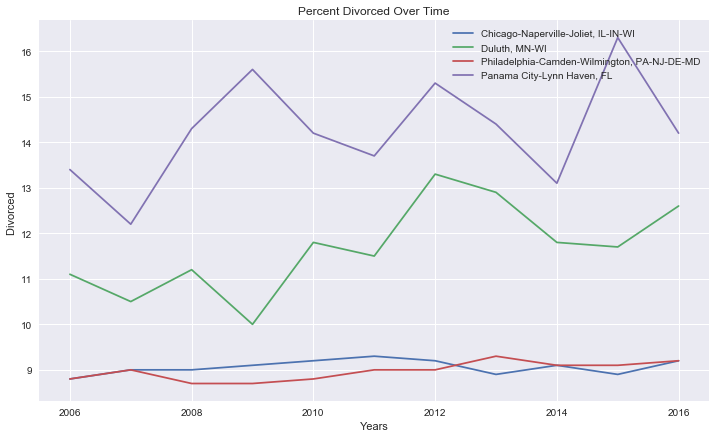

In [33]:
trend_plot('Divorced_', sub_ids, 'Percent Divorced Over Time')

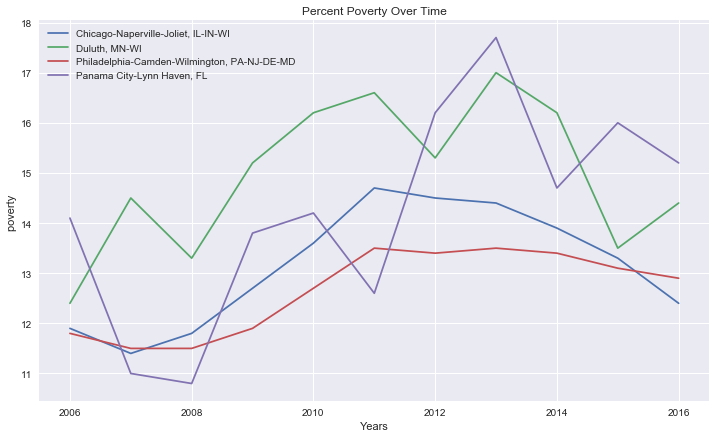

In [34]:
trend_plot('poverty_', sub_ids, 'Percent Poverty Over Time')

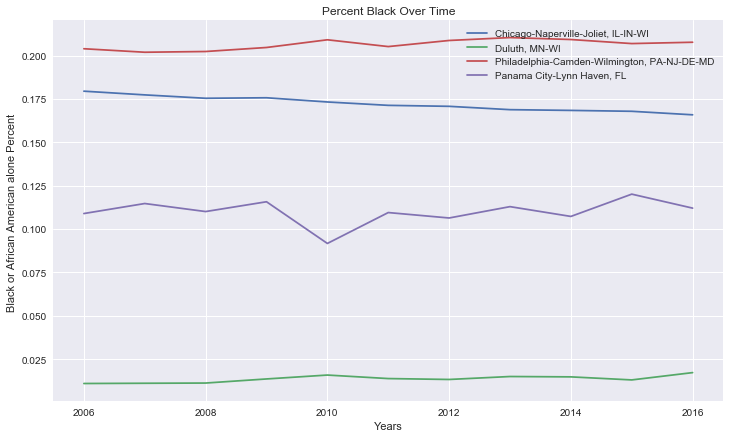

In [35]:
trend_plot('Black or African American alone_Percent_', sub_ids, 'Percent Black Over Time')

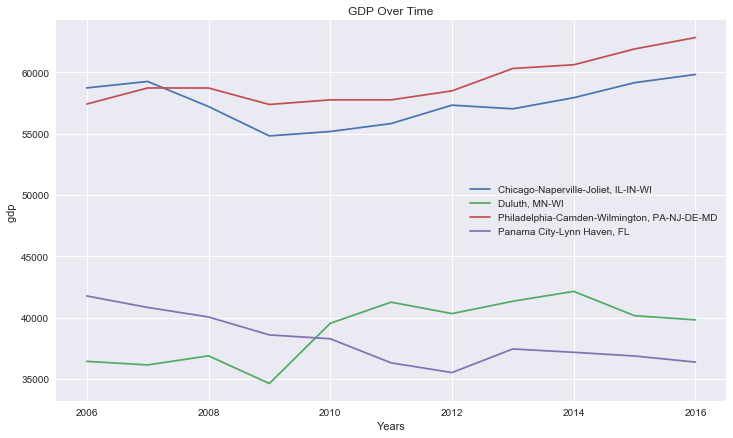

In [36]:
trend_plot('gdp_', sub_ids, 'GDP Over Time')

## Murder Over Time

In [37]:
sub_years = {}
for i in range(2006,2017):
    sub_years[i] = dict_df_year[i].loc[dict_df_year[i]['ID'].isin(sub_ids)]


In [38]:
sub_years[2008].head()

,pop_08,Percent_male_08,Percent_female_08,AGE - Under 5 years_08,AGE - 5 to 9 years_08,AGE - 10 to 14 years_08,AGE - 15 to 19 years_08,AGE - 20 to 24 years_08,AGE - 25 to 29 years_08,AGE - 30 to 34 years_08,...,Asian alone_Percent_08,Native Hawaiian and Other Pacific Islander alone_Percent_08,Some other race alone_Percent_08,Two or more races:_Percent_08,msa_name,Murder 2008,ID,gdp_08,murder_category,murder_rate
76,275336,0.494599,0.505401,5.5,5.7,5.3,7.7,8.4,6.6,5.4,...,0.006505,0.000000,0.000701,0.017161,"Duluth, MN-WI",4.0,20260,36885,0,1.452770
208,163946,0.490924,0.509076,6.6,6.9,6.1,6.2,5.4,6.8,6.4,...,0.017579,0.002049,0.004264,0.040751,"Panama City-Lynn Haven, FL",11.0,37460,40052,1,6.709526
210,5838471,0.483937,0.516063,6.5,6.4,6.6,7.5,6.7,5.9,5.9,...,0.043522,0.000195,0.028367,0.017605,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",530.0,37980,58708,2,9.077719


In [39]:
# looks at sub years and checks whether all ids are there and extracts murders
# if some id's are missing, murders for those are set to zero (e.g. Chicago from 2006 to 2010)
def find_yw_data(sub_years, sub_ids):
    main = []
    for i in range (2006,2017):
        temp = []
        for j in sub_ids:
            if sum((sub_years[i]['ID'])== j) == 1:
                temp.append(sub_years[i][sub_years[i]['ID'] == j]['Murder '+ str(i)].values)
            else:
                temp.append(0)
        main.append(temp)
    return(main)

In [40]:
# use msa just for the feature trends
# plots murder trends given MSA indices
def murder_trend_plot(sub_ids):
    murder_years = np.array(find_yw_data(sub_years,sub_ids))
    new_cols = msa_df.loc[sub_ids]['msa_name'].tolist()
    x = np.arange(2006,2017,1)
    plt.figure(figsize=(16, 8))
    for i in range(len(sub_ids)):
        plt.plot(x,murder_years[:,i],label = new_cols[i])
    plt.legend(loc='best')
    plt.xlabel('Years')
    plt.ylabel('Murders')
    plt.title('Murder Counts Over Time')

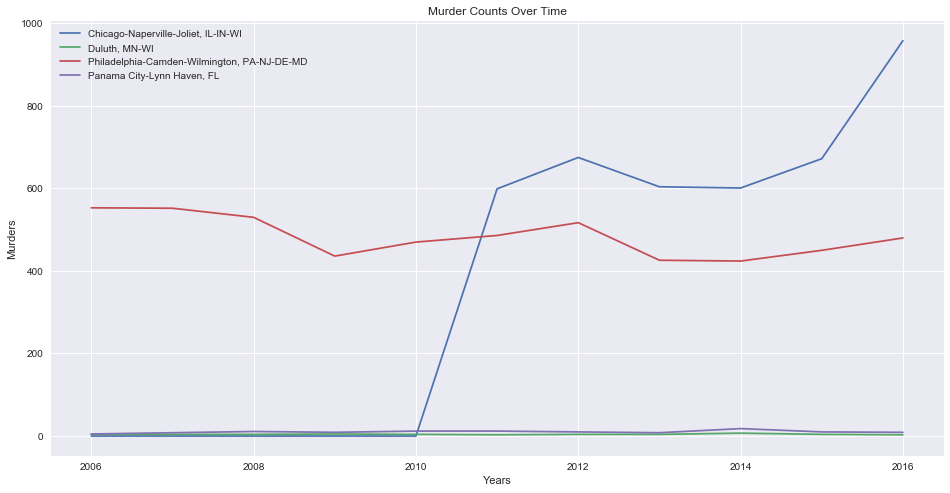

In [41]:
murder_trend_plot(sub_ids)

## Murder by Feature 

In [42]:
# use msa just for the feature trends
# scatter plot of feature against the murder with data from all years

def feature_murder_plot(feature_name, sub_ids, title):
    pc_temp =[]
    sub_years = {}
    for i in range(2006, 2017):
        sub_years[i] = dict_df_year[i].loc[dict_df_year[i]['ID'].isin(sub_ids)]

    for i in range(2006,2017):
        pc_temp.append(msa_df.loc[sub_ids].columns.get_loc(feature_name + '%02d' %(i - 2000)))
    murder_years = np.array(find_yw_data(sub_years, sub_ids))
    # index all rows with interesting sub ids and feature of interest columns
    df_temp = msa_df.loc[sub_ids].iloc[:,pc_temp]
    # add row for years
    df_temp.loc[len(df_temp)] = np.arange(2006, 2017, 1)
    df_temp = df_temp.T
    new_cols = msa_df.loc[sub_ids]['msa_name'].tolist()
    new_cols.append('year')
    df_temp.columns = new_cols 
    plt.figure(figsize=(12, 6))
    for i in range(len(sub_ids)):
        plt.scatter(df_temp.iloc[:,i].values,murder_years[:,i],label = new_cols[i])
    plt.legend(loc='best')
    plt.ylabel('# of Murders')
    plt.xlabel(feature_name.replace("_", " "))
    plt.title(title)
    


We plot some of the features below: 

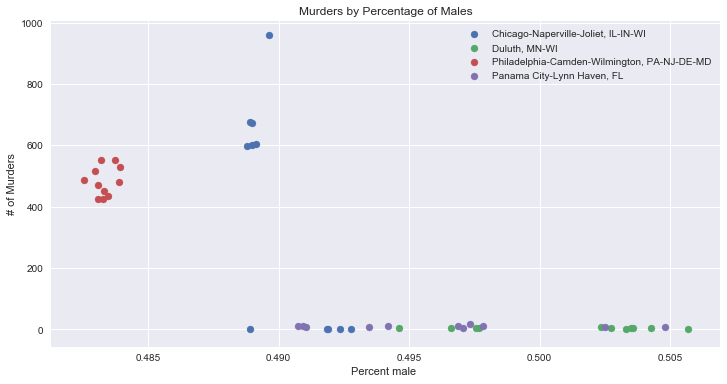

In [43]:
feature_murder_plot('Percent_male_', sub_ids, 'Murders by Percentage of Males')

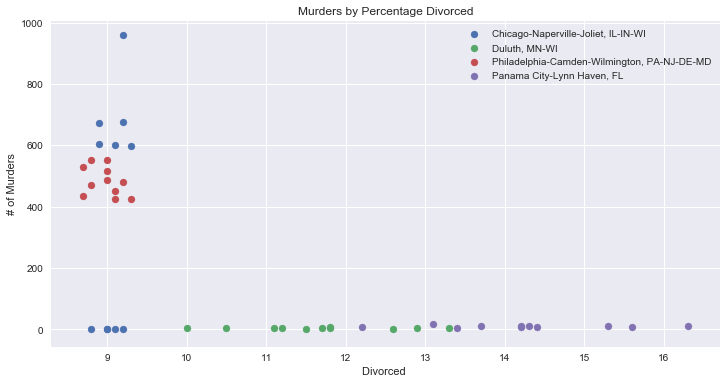

In [44]:
feature_murder_plot('Divorced_', sub_ids, 'Murders by Percentage Divorced')

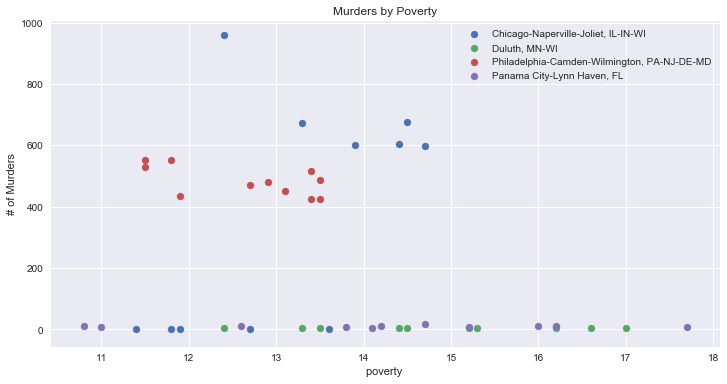

In [45]:
feature_murder_plot('poverty_', sub_ids, 'Murders by Poverty')

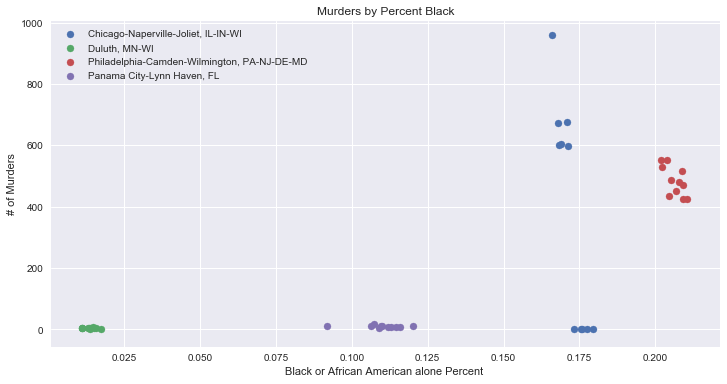

In [46]:
feature_murder_plot('Black or African American alone_Percent_', sub_ids, 'Murders by Percent Black')

****

## Murder on Map of US

We use Geopy to find the longitude and latitiude of each MSA and plot them on a map`

In [47]:
## find lat and long for each msa
geolocator = Nominatim()
# lat_long = []
# for row in unique_id['msa_name']:
#     if geolocator.geocode(row) == None:
#         lat_long.append(np.nan)
#     if geolocator.geocode(row) != None:
#         lat_long.append(geolocator.geocode(row)[1])
       
# # save as file
# with open('outfile', 'wb') as fp:
#     pickle.dump(lat_long, fp)
      
# read in file
with open ('outfile', 'rb') as fp:
    llng = pickle.load(fp)

# split by latitude and longitude 
lat = []
long = []
for i in llng:
    if type(i) is float:
        lat.append(np.nan)
        long.append(np.nan)
    if type(i) is tuple:
        lat.append(i[0])
        long.append(i[1])

lat_long_df = pd.DataFrame([unique_id['ID'].tolist(), lat, long]).T

# some of the lat_longs were wrong
lat_long_df.columns = ['ID', 'latitude', 'longitude']


In [48]:
# add to each df
position_murder_df = {}
for i in range(2006, 2017):
    position_murder_df[i] = dict_df_year[i].merge(lat_long_df, left_on = 'ID', right_on = 'ID', how = 'inner')


In [49]:
# some lat and long were wrong so we drop them
position_murder_df[2006] = position_murder_df[2006][position_murder_df[2006]['msa_name'] != 'Bangor, ME']
position_murder_df[2016] = position_murder_df[2016][position_murder_df[2016]['msa_name'] != 'Bangor, ME']

In [50]:
plotly.tools.set_credentials_file(username ='jeanettejin', api_key ='65684eh97DVINyUzjc0P')

data = [dict(
    lat = position_murder_df[2006]['latitude'],
    lon = position_murder_df[2006]['longitude'],
    text =  position_murder_df[2006]['Murder 2006'].astype(str) + ' count',

    marker = dict(
        size = 10,
        color = position_murder_df[2006]['Murder 2006'],
        colorsrc = "jeanettejin:2:236ccc",
        opacity = 1.0,
        colorscale =  [[0, 'rgb(49,54,149)'], [1./10000, 'rgb(69,117,180)'], [1./1000, 'rgb(113, 189, 206)'], [1./100, 'rgb(254, 173, 144)'], [1./10, 'rgb(232, 78, 37)'], [1./1, 'rgb(226, 9, 9)']],
        colorbar = dict(
            thickness = 10,
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticklen = 3,
            showticksuffix = 'first',
            ticksuffix = " count",
        ),
    ),
    type = 'scattergeo',
) ]

layout = dict(
    geo = dict(
        scope = 'north america',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
        projection = dict(
            type = 'conic conformal',
            rotation = dict(
                lon = -100
            )
        ),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ -140.0, -55.0 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ 20.0, 60.0 ],
            dtick = 5
        )
    ),
    title = 'Murder Counts in US 2006',
)
fig = {'data': data, 'layout': layout }
py.iplot(fig, filename = 'Murder_2006')

In [51]:
plotly.tools.set_credentials_file(username ='jeanettejin', api_key ='65684eh97DVINyUzjc0P')

data = [dict(
    lat = position_murder_df[2016]['latitude'],
    lon = position_murder_df[2016]['longitude'],
    text =  position_murder_df[2016]['Murder 2016'].astype(str) + ' count',

    marker = dict(
        size = position_murder_df[2016]['Murder 2016'] / 10,
        color = 'red',
        colorsrc = "jeanettejin:2:236ccc",
        opacity = 1.0,
    ),
    type = 'scattergeo',
) ]
  
layout = dict(
    geo = dict(
        scope = 'north america',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
        projection = dict(
            type = 'conic conformal',
            rotation = dict(
                lon = -100
            )
        ),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ -140.0, -55.0 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ 20.0, 60.0 ],
            dtick = 5
        )
    ),
    title = 'Murder Counts in US 2016',
)
fig = {'data': data, 'layout': layout }
py.iplot(fig, filename = 'Murder_2016')

## Histograms of Murders Across Years

We can see that most MSA have pretty low murder counts

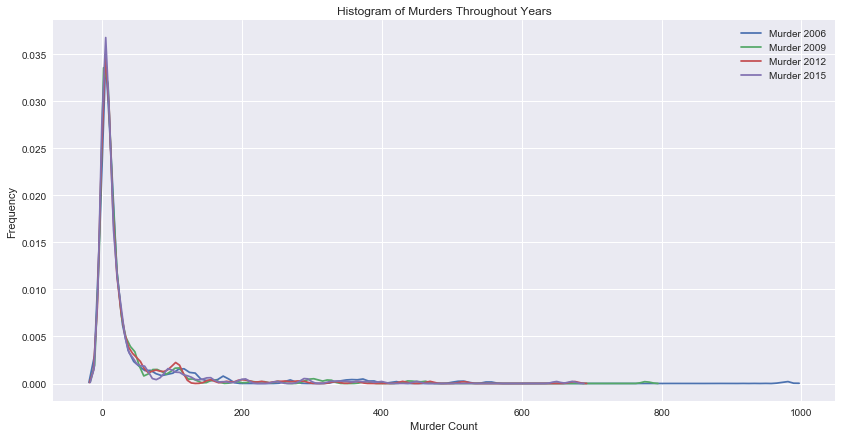

In [52]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set(xlabel = 'Murder Count', ylabel = 'Frequency')
ax.set_title("Histogram of Murders Throughout Years")


for i in range(2006, 2017, 3):
    sns.kdeplot(dict_df_year[i]['Murder ' + str(i)], ax = ax)

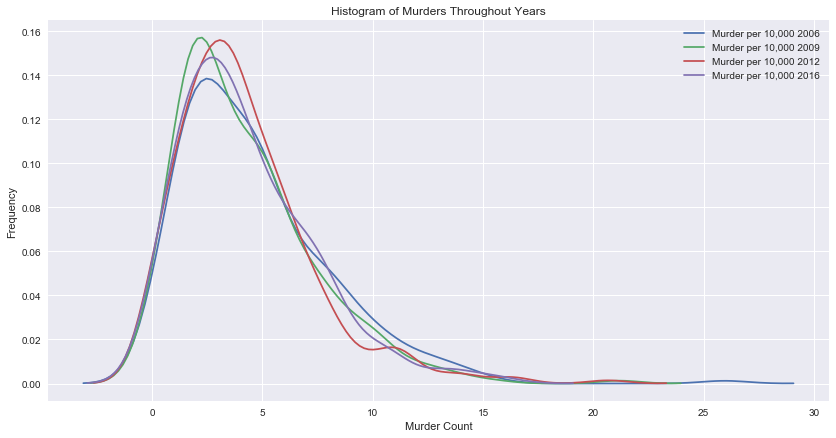

In [53]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set(xlabel = 'Murder Count', ylabel = 'Frequency')
ax.set_title("Histogram of Murders Throughout Years")



for i in range(2006, 2017, 3):
    sns.kdeplot(dict_df_year[i]['murder_rate'], ax = ax)
   
    
plt.legend(['Murder per 10,000 2006', 'Murder per 10,000 2009', 'Murder per 10,000 2012', 'Murder per 10,000 2016']) 

## Feature vs Murder or Murder / Population by Group Through TIme

We define a function that plots murder's by feature in certain circumstances, plotted throughout various years. If option is 0 we plot murder by feature for various years. If option is 1, we plot murder by feature and differerentiate each point by weather it's murder_category is low, medium, or high across multiple years. If option is 2, we plot murder divided by population by feature across multiple years. 

In [54]:
def feature_x_time(title, feature, option = 0):

    if option is 0: 
        fig, ax = plt.subplots(1, 4, figsize=(20, 10))
        plt.subplots_adjust(top = .94)
        fig.suptitle(title)
        for i in range(2006, 2017, 3):
            ind = int((i - 2006) / 3)
            sns.regplot(feature + '%02d' % (i - 2000), 'Murder ' + str(i), dict_df_year[i], ax = ax[ind])
            sns.set(font_scale = .7)

    if option is 1:
        for i in range(2006, 2017, 3):
            ind = int((i - 2006) / 3)
            sns.lmplot(feature + '%02d' % (i - 2000), 'Murder ' + str(i), hue = "murder_category", data = dict_df_year[i], size = 6)
    
    if option is 2: 
        fig, ax = plt.subplots(1, 4, figsize=(20, 10))
        plt.subplots_adjust(top = .94)
        fig.suptitle(title)

        for i in range(2006, 2017, 3):
            ind = int((i - 2006) / 3)
            sns.regplot(feature + '%02d' % (i - 2000), 'murder_rate', dict_df_year[i], ax = ax[ind])
            ax[ind].set(ylim=(0, 6))



We can see that murder and population seem to have a strong linear relationship. For the remainder of the variables, we also include option 2, so we can see how each feature varies with murder/population

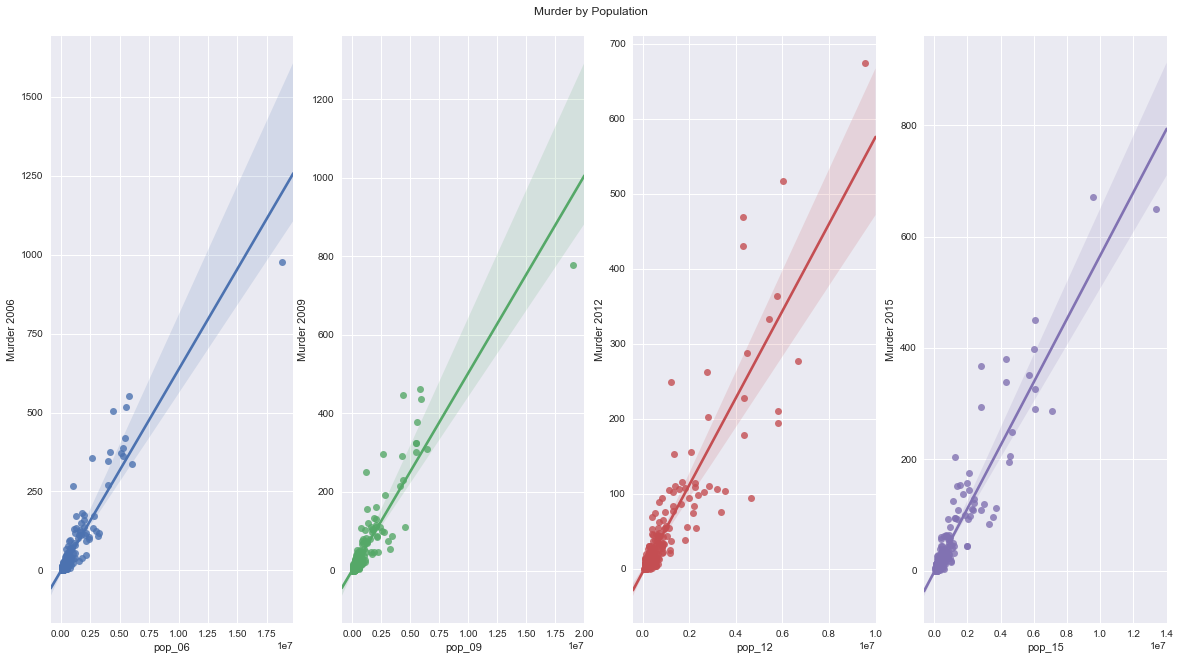

In [55]:
feature_x_time("Murder by Population", 'pop_')

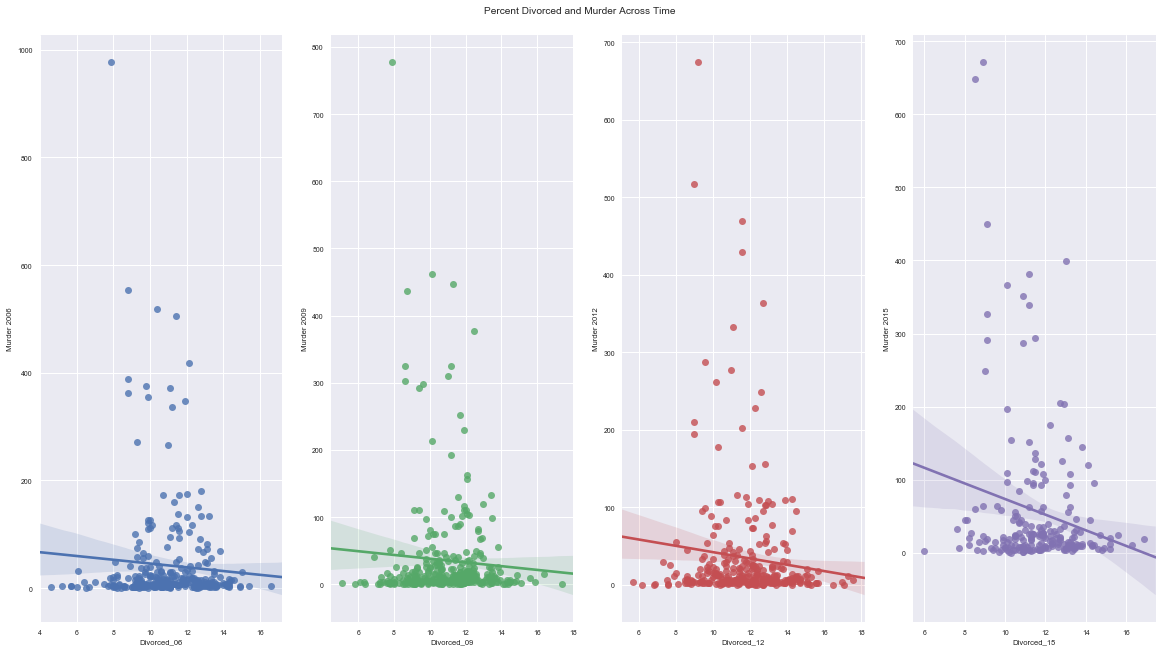

In [56]:
feature_x_time("Percent Divorced and Murder Across Time", "Divorced_")

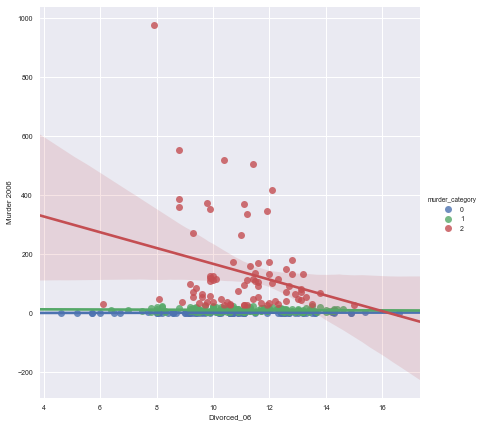

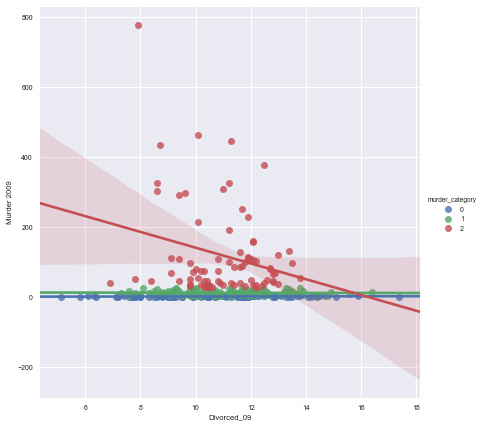

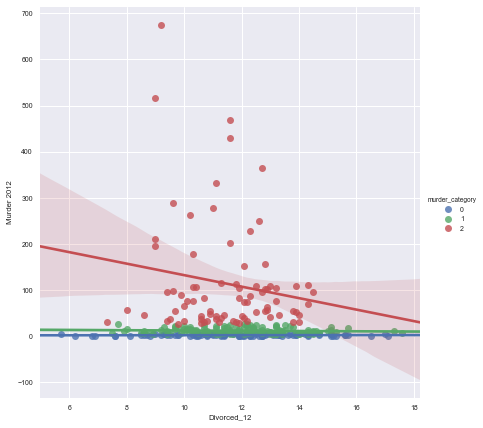

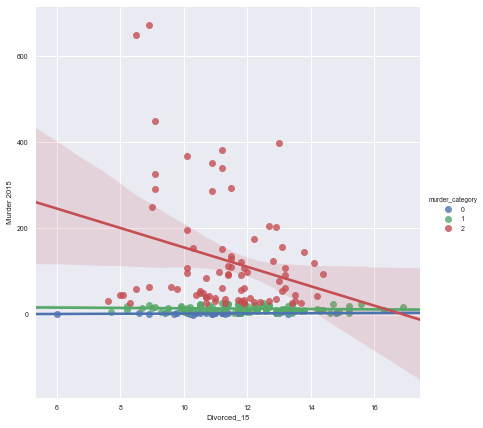

In [57]:
feature_x_time("Percent Divorced and Murder Across Time", "Divorced_", option = 1)

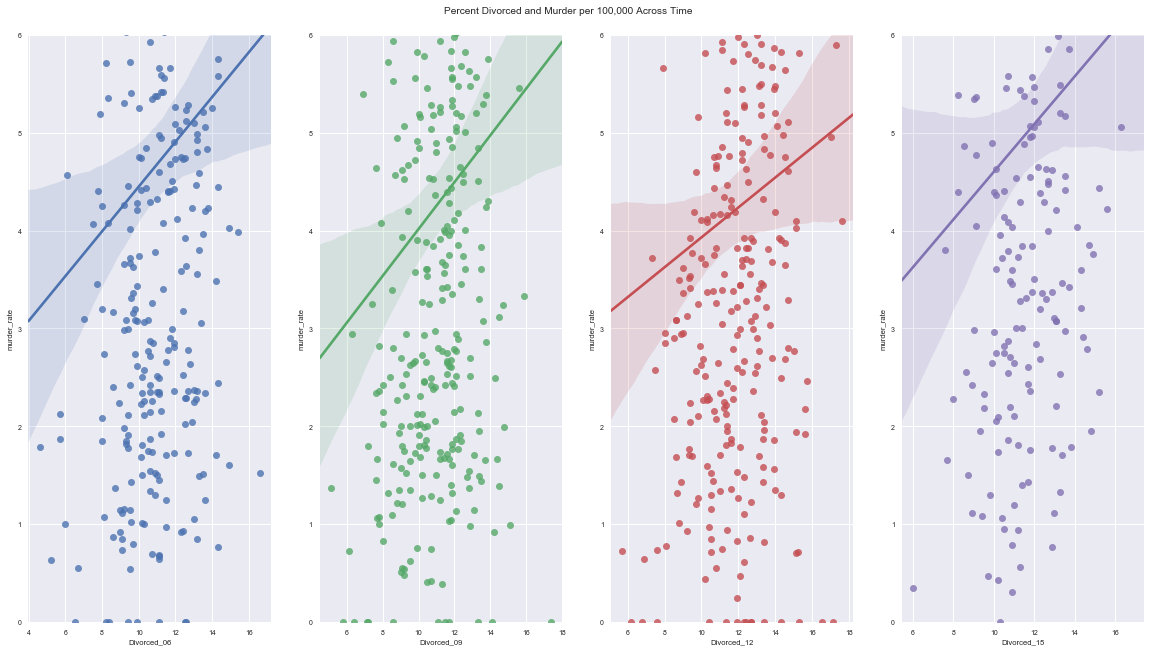

In [58]:
feature_x_time("Percent Divorced and Murder per 100,000 Across Time", "Divorced_", option = 2)

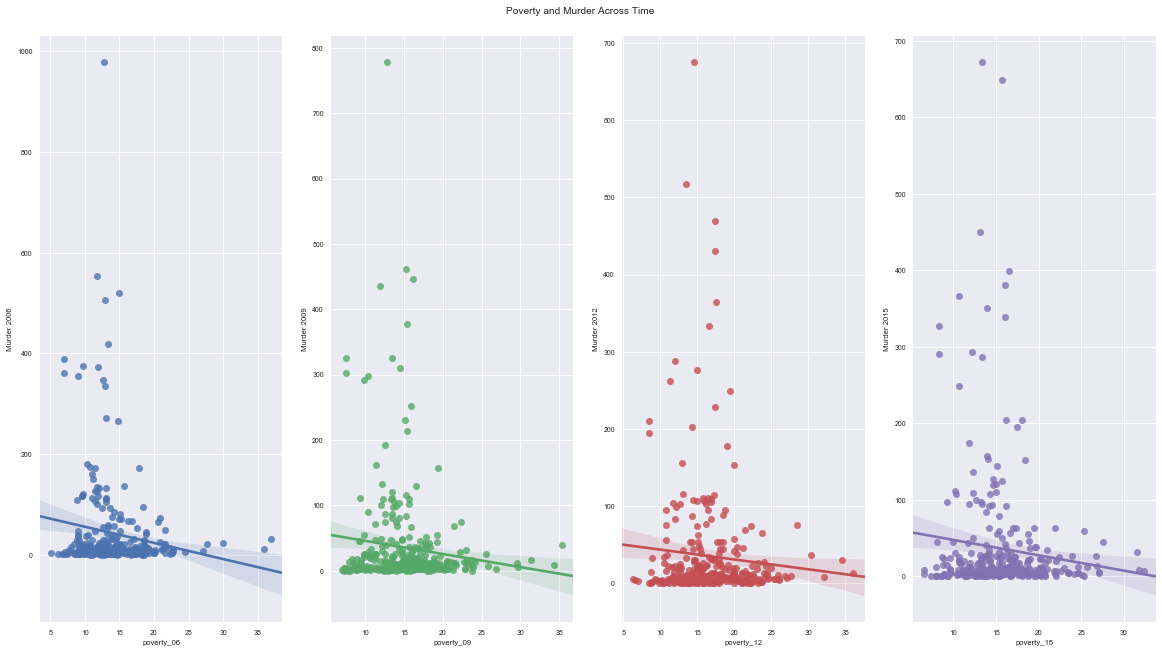

In [59]:
feature_x_time('Poverty and Murder Across Time', 'poverty_')

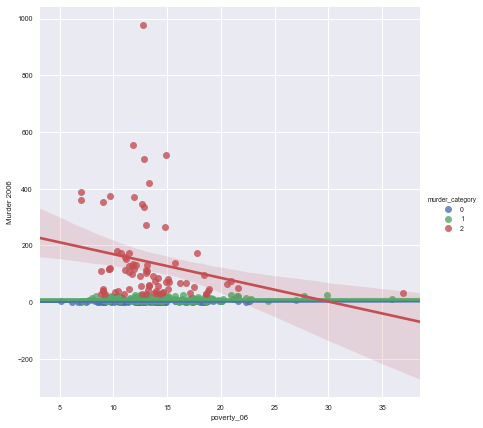

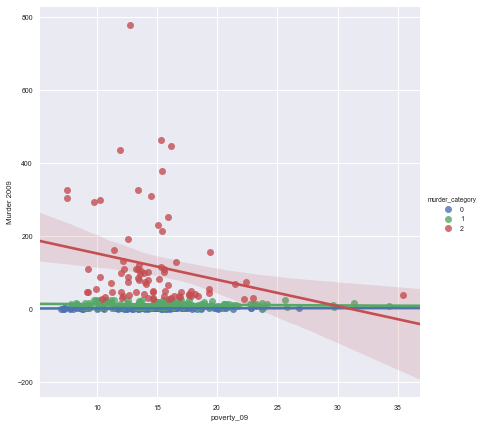

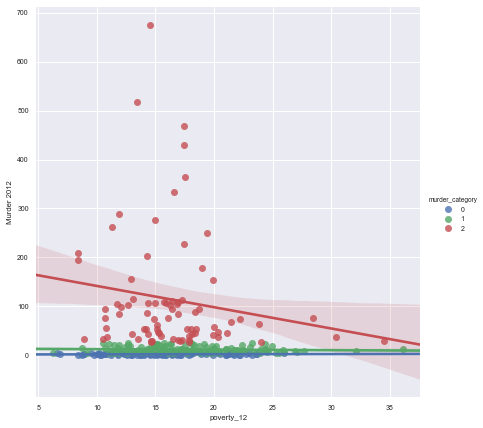

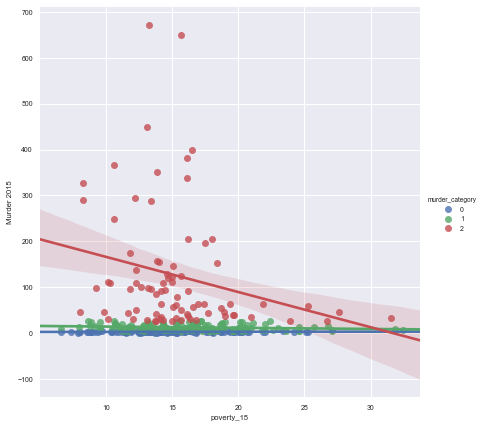

In [60]:
feature_x_time('Poverty and Murder Across Time', 'poverty_', option = 1)

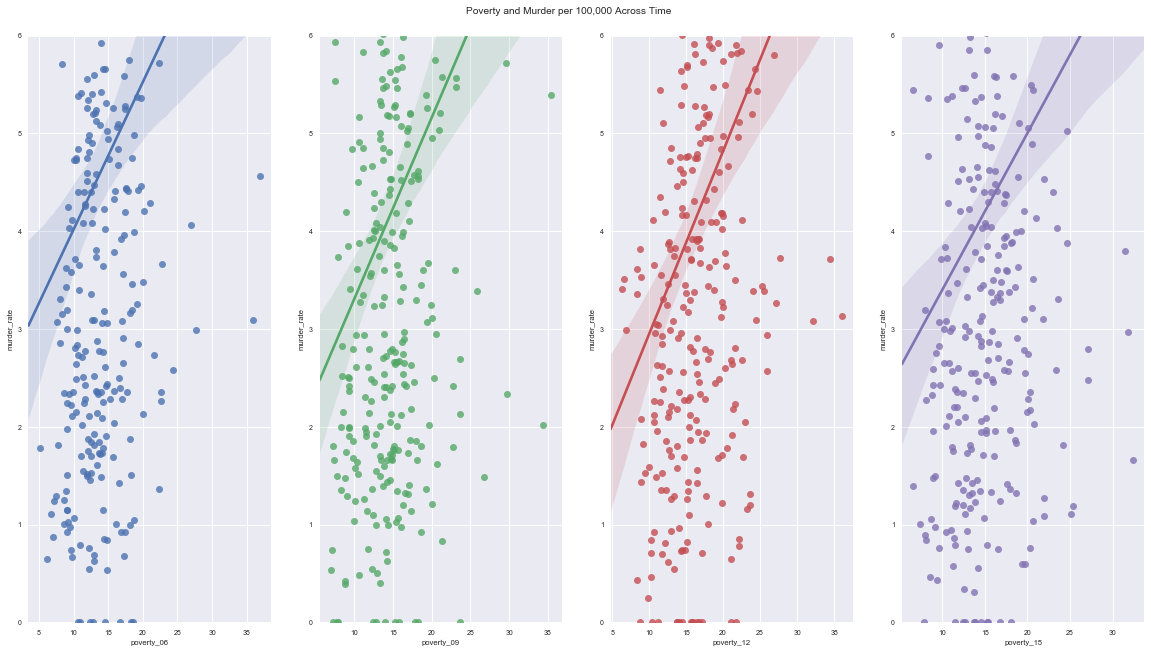

In [61]:
feature_x_time('Poverty and Murder per 100,000 Across Time', 'poverty_', option = 2)

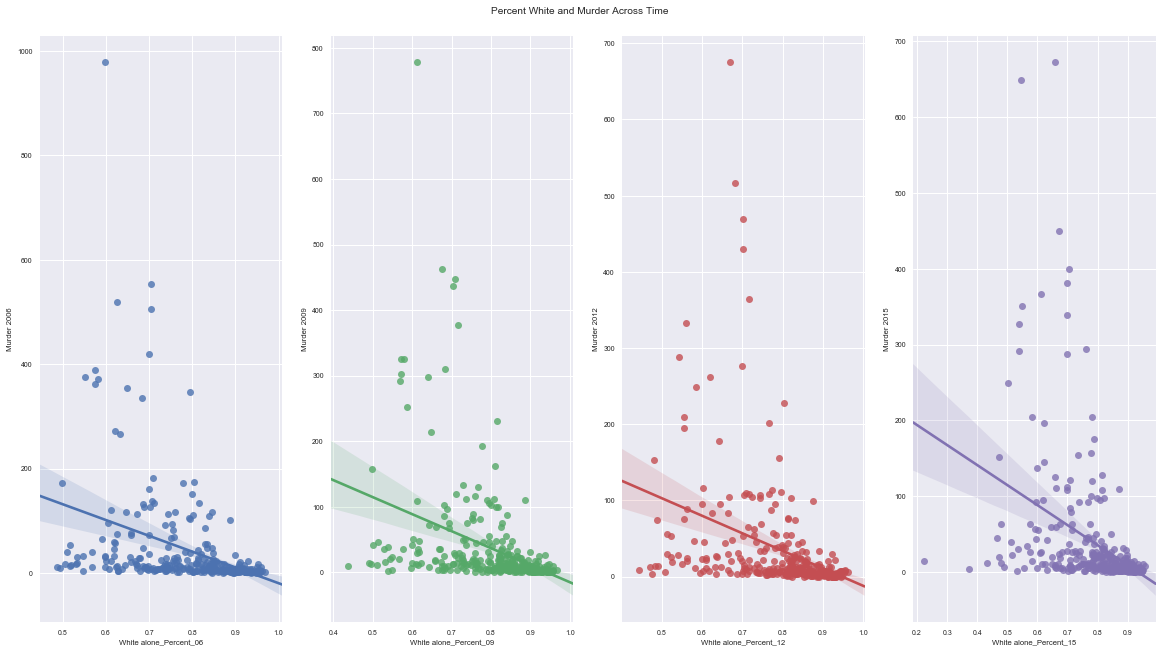

In [62]:
feature_x_time('Percent White and Murder Across Time', 'White alone_Percent_')

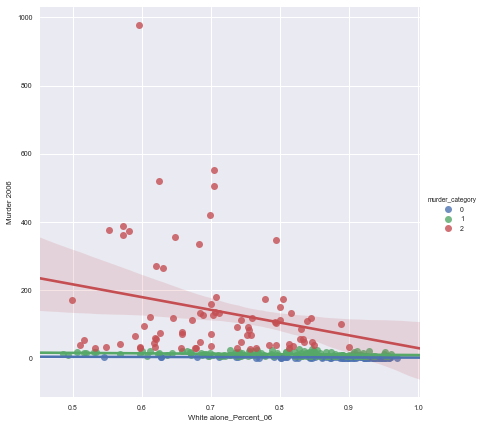

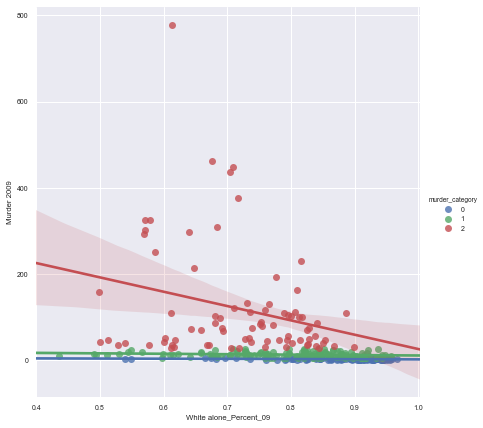

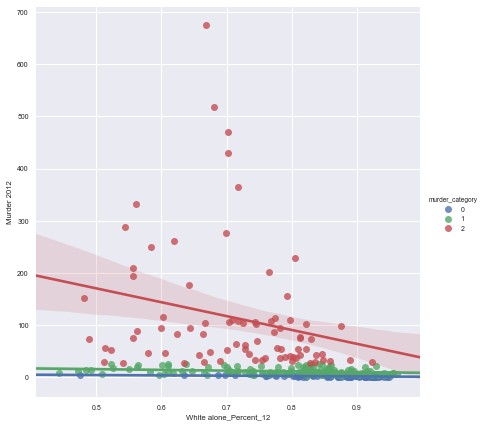

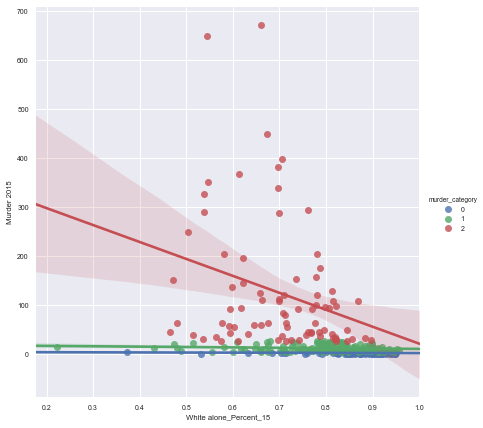

In [63]:
feature_x_time('Percent White and Murder Across Time', 'White alone_Percent_', option = 1)

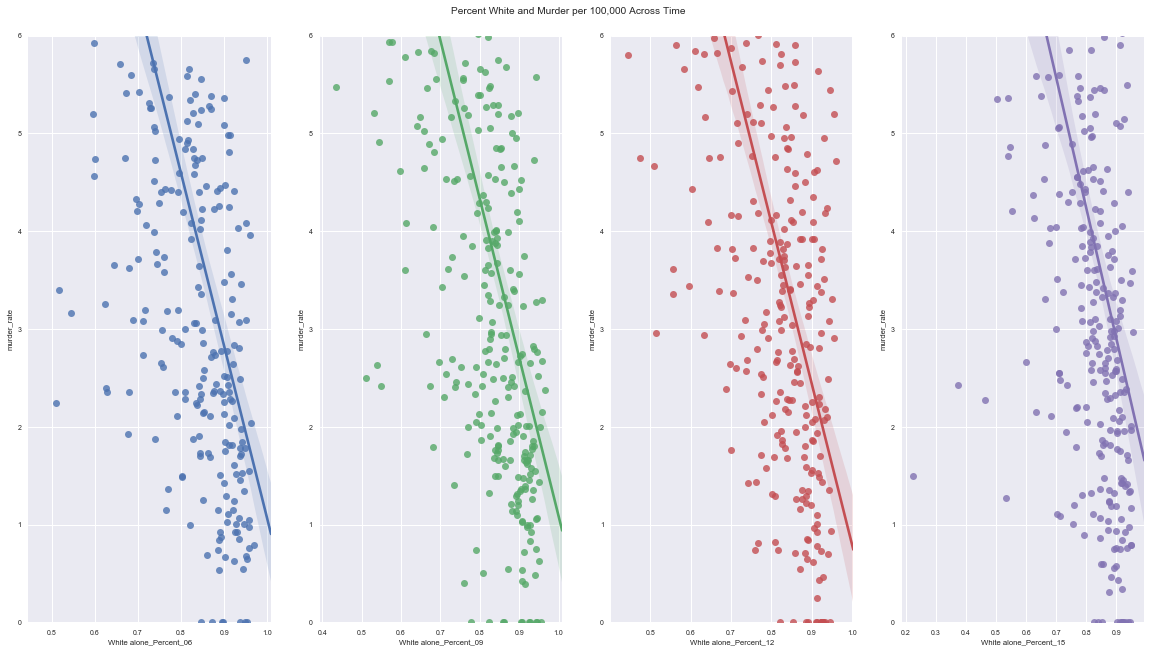

In [64]:
feature_x_time('Percent White and Murder per 100,000 Across Time', 'White alone_Percent_', option = 2)

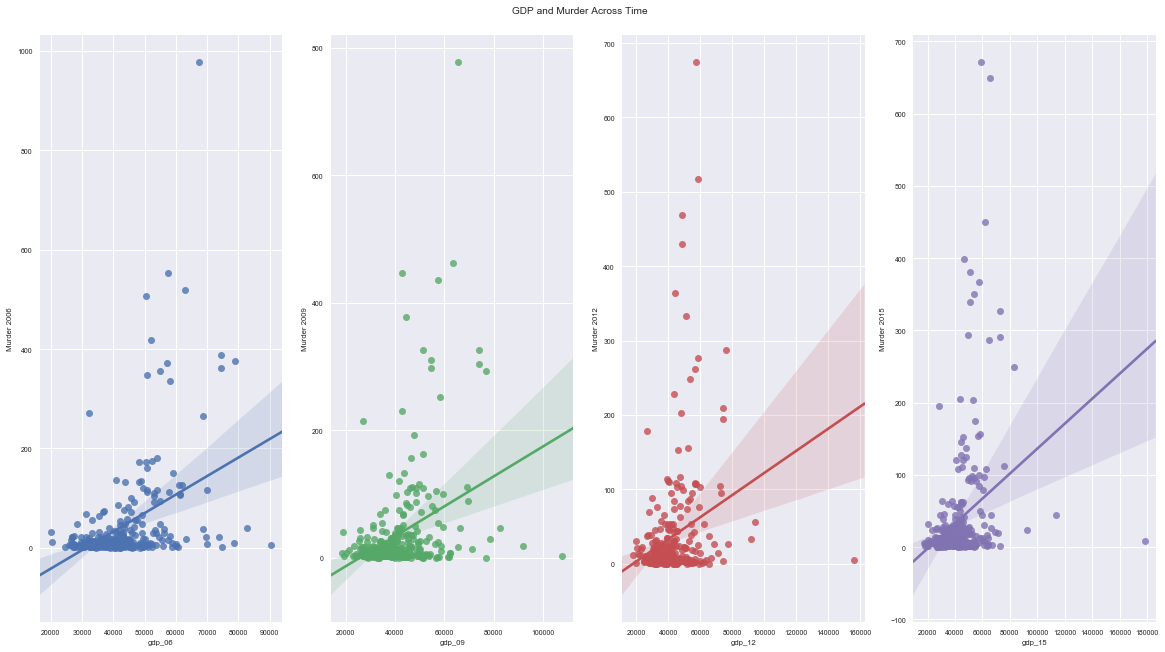

In [65]:
feature_x_time("GDP and Murder Across Time", 'gdp_')

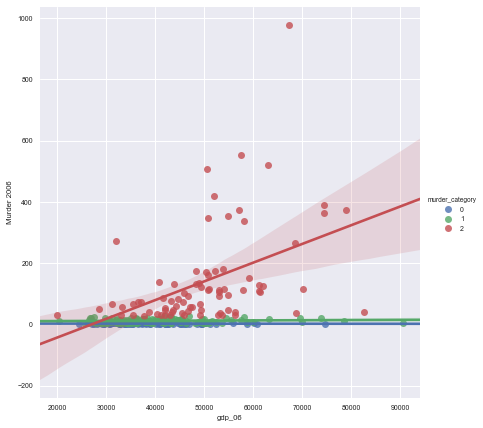

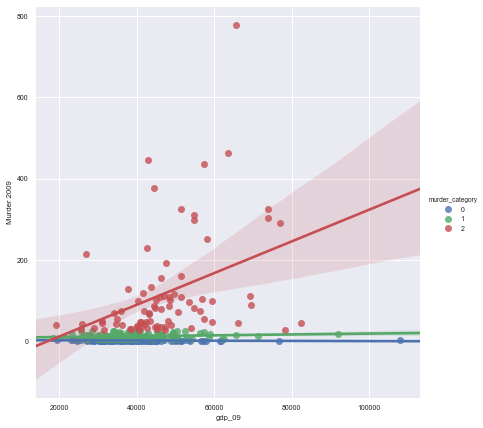

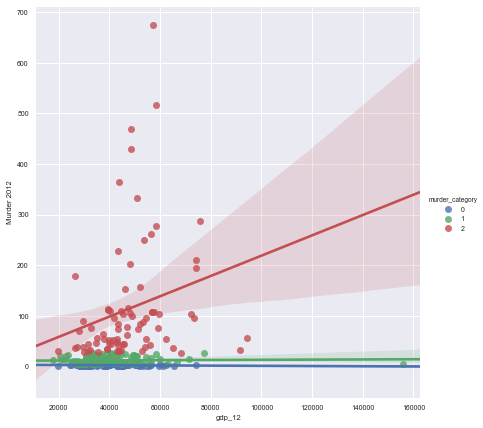

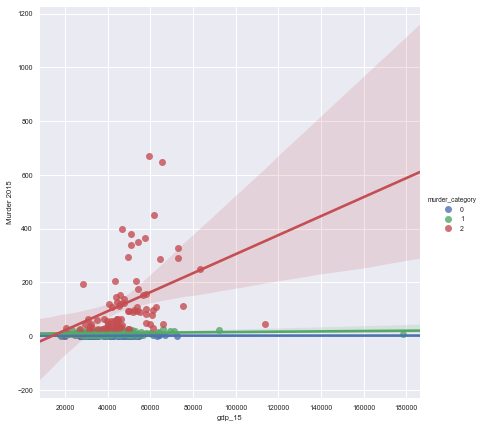

In [66]:
feature_x_time("GDP and Murder Across Time", 'gdp_', option = 1)

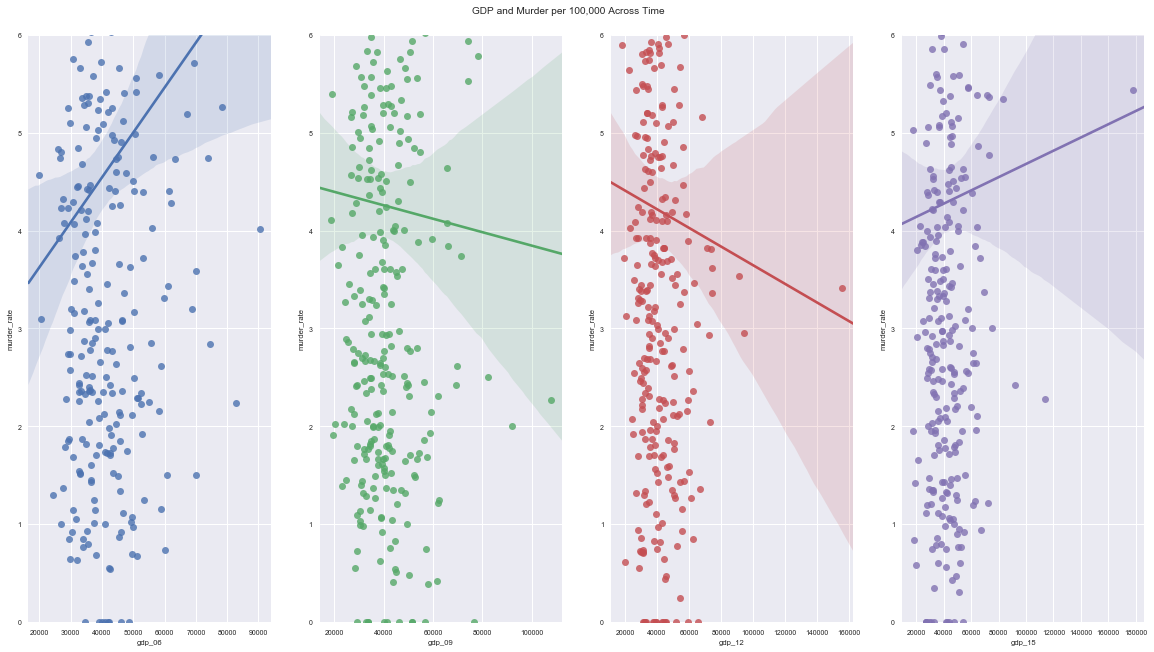

In [67]:
feature_x_time("GDP and Murder per 100,000 Across Time", 'gdp_', option = 2)

## Feature-Feature Correlation

Looks like multicollinearity will be an issue. We will address this through feature selection

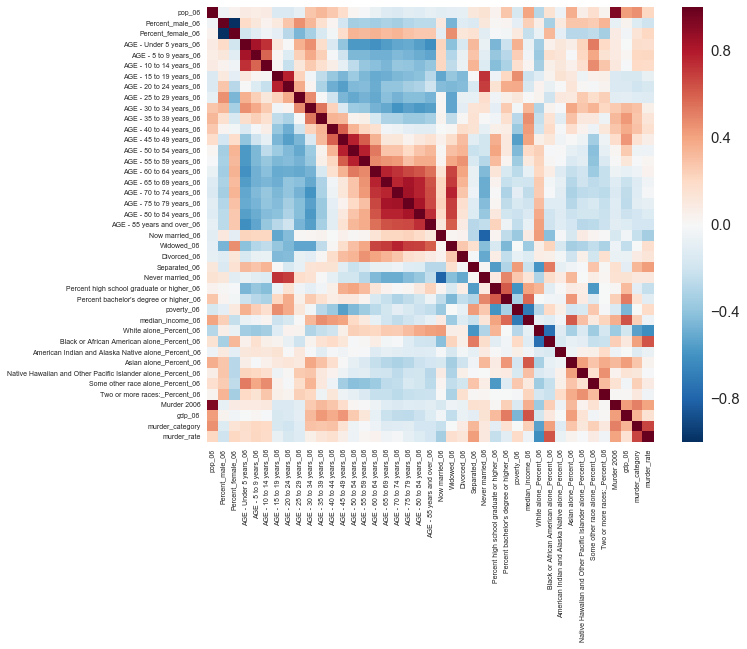

In [68]:
fig, ax = plt.subplots(figsize=(10, 8))

# corr heat map
sns.set(font_scale = 1.5)
sns.heatmap(dict_df_year[2006].corr(), ax = ax)


# Modeling

Before we do our model, lets first collapse the some of our age columns.

In [69]:
# collapse age columns and drop specific columns
for i in range(2006, 2017):
    dict_df_year[i]['under_18_' + '%02d' % (i - 2000)] = dict_df_year[i]['AGE - Under 5 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 5 to 9 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 10 to 14 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 15 to 19 years_' + '%02d' % (i - 2000)]  
    dict_df_year[i]['20_to_40_' + '%02d' % (i - 2000)] = dict_df_year[i]['AGE - 20 to 24 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 25 to 29 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 30 to 34 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 35 to 39 years_' + '%02d' % (i - 2000)]  
    dict_df_year[i]['40_to_60_' + '%02d' % (i - 2000)] = dict_df_year[i]['AGE - 40 to 44 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 45 to 49 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 50 to 54 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 55 to 59 years_' + '%02d' % (i - 2000)]  
    dict_df_year[i]['60_above_' + '%02d' % (i - 2000)] = dict_df_year[i]['AGE - 60 to 64 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 65 to 69 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 70 to 74 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 75 to 79 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 80 to 84 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 85 years and over_' + '%02d' % (i - 2000)]  
    dict_df_year[i] = dict_df_year[i].drop(['AGE - Under 5 years_' + '%02d' % (i - 2000), 'AGE - 5 to 9 years_' + '%02d' % (i - 2000), 'AGE - 10 to 14 years_' + '%02d' % (i - 2000), 'AGE - 15 to 19 years_'  + '%02d' % (i - 2000), 'AGE - 20 to 24 years_' + '%02d' % (i - 2000), 'AGE - 25 to 29 years_' + '%02d' % (i - 2000), 'AGE - 30 to 34 years_' + '%02d' % (i - 2000), 'AGE - 35 to 39 years_' + '%02d' % (i - 2000), 'AGE - 40 to 44 years_' + '%02d' % (i - 2000), 'AGE - 45 to 49 years_' + '%02d' % (i - 2000), 'AGE - 50 to 54 years_' + '%02d' % (i - 2000), 'AGE - 55 to 59 years_' + '%02d' % (i - 2000), 'AGE - 60 to 64 years_' + '%02d' % (i - 2000), 'AGE - 65 to 69 years_' + '%02d' % (i - 2000), 'AGE - 70 to 74 years_' + '%02d' % (i - 2000), 'AGE - 75 to 79 years_' + '%02d' % (i - 2000), 'pop_'+ '%02d' % (i - 2000), 'murder_category'], axis = 1)

In [70]:
dict_avg = {}

for i in range(2006,2017):
    dict_avg[i] = pd.DataFrame.copy(dict_df_year[i])

In [71]:
# function that standarizes df with 2006 min, max and range and returns the x_train and y_train
def preprocess(year, columns, y_name):
    
    # empty lists for column names
    columns_year = []
    columns_06 = []
    year_2 = '%02d' % (year - 2000)
    year_06 = '%02d' % 6
    
    # make columns names 
    for column in columns:
        columns_year.append(column + year_2)
        columns_06.append(column + year_06)
    
    # df 
    df = dict_df_year[year].dropna()
    
    # split
    x_train = df[columns_year]
    y_train = df[[y_name]]
    
    # scale df
    df_scale = dict_df_year[2006].dropna()
   
    # select columns
    columns_scale = df_scale[columns_06]
    x_columns = x_train.columns.tolist()
    
    # standardize
    scaler = StandardScaler().fit(columns_scale)
    x_train[x_columns] = scaler.transform(x_train)
    
    return x_train, y_train

# function that adds polynomial terms to x_train and x_test
# polfeatures
def more_terms(x_train, x_test, degree):
    columns = base_col
    poly = PolynomialFeatures(degree, interaction_only = False, include_bias = False)
    
    x_trainpoly = poly.fit_transform(x_train)
    x_testpoly = poly.fit_transform(x_test)
    feature = poly.get_feature_names(columns)
    x_train_poly = pd.DataFrame(x_trainpoly, columns = feature)
    x_test_poly = pd.DataFrame(x_testpoly, columns = feature)
    
    return x_train_poly, x_test_poly
   


We make a dict for all the features in x_year and all the murder counts over population in y_year

In [72]:
# initialize dicts
x_year = {}
y_year = {}

# features
columns = ['Percent_male_' , 'under_18_', '20_to_40_', '40_to_60_', '60_above_', 'Now married_', 'Widowed_', 'Divorced_', 'Separated_', 'Never married_', 'Percent high school graduate or higher_', "Percent bachelor's degree or higher_", 'poverty_', 'median_income_', 'White alone_Percent_', 'Black or African American alone_Percent_', 'American Indian and Alaska Native alone_Percent_', 'Asian alone_Percent_', 'Native Hawaiian and Other Pacific Islander alone_Percent_', 'Some other race alone_Percent_', 'Two or more races:_Percent_', 'gdp_']


# for each year scale and split and put into dict
for year in range(2006, 2017):
    
    xyear, yyear = preprocess(year, columns, 'murder_rate')
    
    x_year[year] = xyear
    y_year[year] = yyear

## Base Model (Ridge and Lasso)

We use the gender, age, and income as our basemodel. To account for time series, for each feature and year, we obtain a coefficent and use these to fit a model to each feature. We predict the coefficient for each feature, which gives us our model for 2016. We use RidgeCV and LassoCV to model 2016 data and make predictions on the murder/population.

In [73]:
# col
base_col = ['Percent_male_' , 'under_18_', '20_to_40_', '40_to_60_', '60_above_', 'median_income_']

# initialize dicts
x_yearb = {}
y_yearb = {}

# split select feature for every year and fil dict
for year in range(2006, 2017):

    xbyear, ybyear = preprocess(year, base_col, 'murder_rate')
    
    x_yearb[year] = xbyear
    y_yearb[year] = ybyear

In [74]:
# initialize df
coefficients_lassob = pd.DataFrame()
coefficients_ridgeb = pd.DataFrame()

# constants
constant_lassob = []
constant_ridgeb = []

# add col names
coefficients_lassob['columns'] = base_col
coefficients_ridgeb['columns'] = base_col

# get betas for every year using lasso cv and ridge cv
for i in range(2006, 2016):
    lassob = LassoCV().fit(x_yearb[i], y_yearb[i].values.reshape(-1, 1))
    coefficients_lassob[i] = lassob.coef_
    
    ridgeb = RidgeCV().fit(x_yearb[i], y_yearb[i].values.reshape(-1, 1))
    coefficients_ridgeb[i] = ridgeb.coef_[0]  
    
    # constants
    constant_lassob.append(lassob.intercept_)
    constant_ridgeb.append(ridgeb.intercept_)
    

In [75]:
# transpose and rename
coefficients_lassob = rename(coefficients_lassob.T)
coefficients_ridgeb = rename(coefficients_ridgeb.T)

In [76]:
# show
coefficients_lassob.head()

,Percent_male_,under_18_,20_to_40_,40_to_60_,60_above_,median_income_
2006,-0.640029,0.882617,-0.108982,0.444397,-0,-0.0501331
2007,-0.434509,1.01228,-0.0344746,0.643091,-0,-0.379183
2008,-0.661512,0.87094,-0,0.24985,-0,-0.0917136
2009,-0.519636,0.733181,-0.000297521,0.354195,-0,-0.465388
2010,-0.654053,0.317147,-0,0.436378,-0.394344,-0.404777


In [77]:
# show
coefficients_ridgeb.head()

,Percent_male_,under_18_,20_to_40_,40_to_60_,60_above_,median_income_
2006,-0.635164,0.697911,-0.35722,0.346686,-0.313517,-0.124067
2007,-0.434678,0.643388,-0.400622,0.363601,-0.457374,-0.394092
2008,-0.665104,0.663585,-0.309884,0.142336,-0.397116,-0.180151
2009,-0.530811,0.524614,-0.263348,0.229722,-0.345614,-0.514892
2010,-0.663024,0.344533,-0.0204428,0.487956,-0.437737,-0.444311


### Base Model Visualize 

####  LassoCV

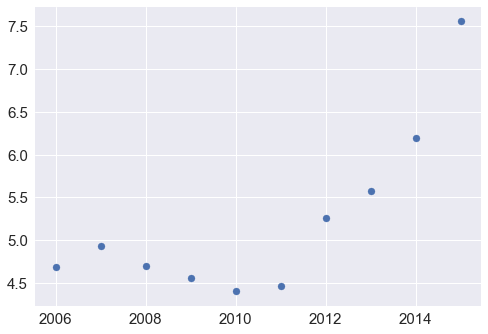

In [78]:
plt.scatter(np.arange(2006, 2016, 1), constant_lassob)

([<matplotlib.axis.XTick at 0x1242be320>,
 <a list of 5 Text xticklabel objects>)

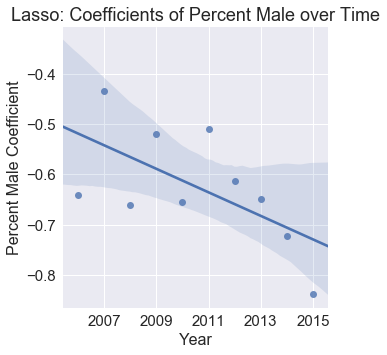

In [79]:
sns.lmplot(x = 'index', y = 'Percent_male_', data = coefficients_lassob.reset_index(), fit_reg = True)
plt.title("Lasso: Coefficients of Percent Male over Time")
plt.ylabel('Percent Male Coefficient', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.xticks([2007, 2009, 2011, 2013, 2015])

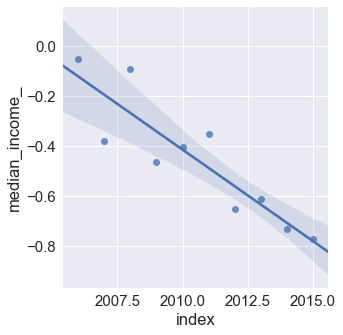

In [80]:
sns.lmplot(x = 'index', y = 'median_income_', data= coefficients_lassob.reset_index(), fit_reg = True)


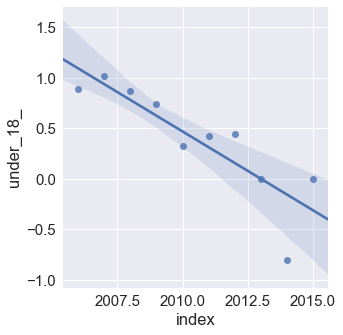

In [81]:
sns.lmplot(x = 'index', y = 'under_18_', data= coefficients_lassob.reset_index(), fit_reg = True)


#### Ridge CV

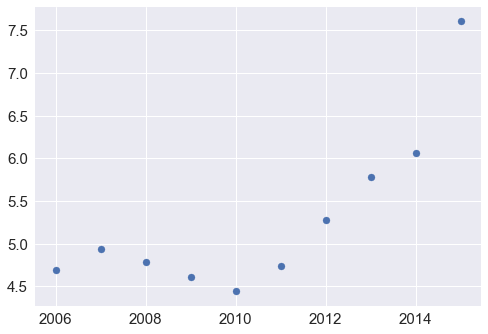

In [82]:
plt.scatter(np.arange(2006, 2016, 1), constant_ridgeb)

([<matplotlib.axis.XTick at 0x11e7b20b8>,
 <a list of 5 Text xticklabel objects>)

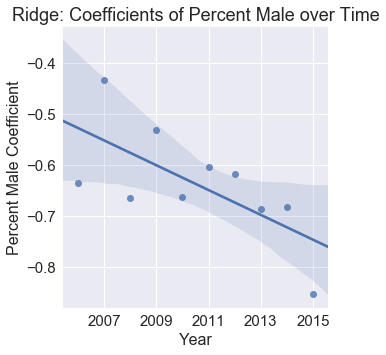

In [83]:
sns.lmplot(x = 'index', y = 'Percent_male_', data = coefficients_ridgeb.reset_index(), fit_reg = True)
plt.title("Ridge: Coefficients of Percent Male over Time")
plt.ylabel('Percent Male Coefficient', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.xticks([2007, 2009, 2011, 2013, 2015])

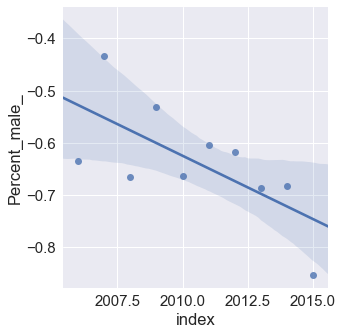

In [84]:
sns.lmplot(x = 'index', y = 'Percent_male_', data= coefficients_ridgeb.reset_index(), fit_reg = True)


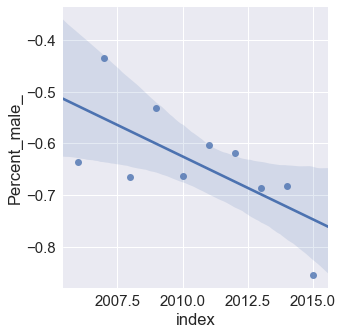

In [85]:
sns.lmplot(x = 'index', y = 'Percent_male_', data= coefficients_ridgeb.reset_index(), fit_reg = True)


### Base Model: Predicting 2016 Beta



In [86]:
coefficients_lassob

,Percent_male_,under_18_,20_to_40_,40_to_60_,60_above_,median_income_
2006,-0.640029,0.882617,-0.108982,0.444397,-0,-0.0501331
2007,-0.434509,1.01228,-0.0344746,0.643091,-0,-0.379183
2008,-0.661512,0.87094,-0,0.24985,-0,-0.0917136
2009,-0.519636,0.733181,-0.000297521,0.354195,-0,-0.465388
2010,-0.654053,0.317147,-0,0.436378,-0.394344,-0.404777
2011,-0.510295,0.422349,-0.000609473,0.278687,-0,-0.352267
2012,-0.612182,0.443794,-0,0.80993,-0.453153,-0.650738
2013,-0.648021,0,-0,0.378217,-0.586899,-0.611886
2014,-0.722185,-0.802668,-0.196126,0.0961882,-1.42999,-0.733343
2015,-0.837259,-0,0,0.796936,-1.01884,-0.773814


In [87]:
coefficients_ridgeb

,Percent_male_,under_18_,20_to_40_,40_to_60_,60_above_,median_income_
2006,-0.635164,0.697911,-0.35722,0.346686,-0.313517,-0.124067
2007,-0.434678,0.643388,-0.400622,0.363601,-0.457374,-0.394092
2008,-0.665104,0.663585,-0.309884,0.142336,-0.397116,-0.180151
2009,-0.530811,0.524614,-0.263348,0.229722,-0.345614,-0.514892
2010,-0.663024,0.344533,-0.0204428,0.487956,-0.437737,-0.444311
2011,-0.603805,0.382543,-0.253286,0.420124,-0.422726,-0.560229
2012,-0.617557,0.315643,-0.161369,0.699032,-0.642465,-0.655928
2013,-0.686196,0.125453,0.0942125,0.606812,-0.57452,-0.685282
2014,-0.682826,-0.138663,0.362999,0.512965,-0.629696,-0.687292
2015,-0.853578,0.0652424,0.193498,0.923873,-0.881284,-0.800873


In [88]:
# our x values are the indexs (year 2006 to 2015)
x = coefficients_ridgeb.index.values

# initialize dataframes to store projected betas for 2016 model
model_lassob = pd.DataFrame()
model_lassob['columns'] = base_col

model_ridgeb = pd.DataFrame()
model_ridgeb['columns'] = base_col

# empty lists to fill 
predict_lassob = []
predict_ridgeb = []

# for every column
for col in base_col: 
    
    # fit a regression to the betas of each year
    regress_lassob = LinearRegression().fit(x.reshape(10, 1), coefficients_lassob[col])
    regress_ridgeb = LinearRegression().fit(x.reshape(10, 1), coefficients_ridgeb[col])
    
    # predict the beta of 2016
    predict_lassob.append(regress_lassob.predict(2016).tolist()[0])
    predict_ridgeb.append(regress_ridgeb.predict(2016).tolist()[0])
    
# model the constant
regress_lassocb = LinearRegression().fit(x.reshape(10,1), constant_lassob)
const_lassob = regress_lassocb.predict(2016)[0]
regress_ridgecb = LinearRegression().fit(x.reshape(10,1), constant_ridgeb)
const_ridgeb = regress_ridgecb.predict(2016)[0]
    
# add to df
model_lassob['coefficients'] = predict_lassob
model_ridgeb['coefficients'] = predict_ridgeb

In [89]:
# show
model_lassob

,columns,coefficients
0,Percent_male_,-0.752476
1,under_18_,-0.470898
2,20_to_40_,-0.039064
3,40_to_60_,0.488650
4,60_above_,-1.157626
5,median_income_,-0.854546


In [90]:
# show
model_ridgeb

,columns,coefficients
0,Percent_male_,-0.770915
1,under_18_,-0.119173
2,20_to_40_,0.301633
3,40_to_60_,0.803401
4,60_above_,-0.779495
5,median_income_,-0.878323


### Base Model Performance

In [91]:
# column of 1
ones = np.ones((x_yearb[2016].shape[0], 1))

# add constant to coefficient list
ylassob = model_lassob['coefficients'].values.tolist()
ylassob.insert(0, const_lassob)

# add constant to coefficient list
yridgeb = model_ridgeb['coefficients'].values.tolist()
yridgeb.insert(0, const_ridgeb)

# predict
lassob_hat = np.dot(np.hstack((ones, x_yearb[2016])), np.array([ylassob]).T) 
ridgeb_hat = np.dot(np.hstack((ones, x_yearb[2016])), np.array([yridgeb]).T)

# report
print('The R2 on the test set for using lasso to model the coefficients is', r2_score(y_yearb[2016] , lassob_hat.ravel()))
print('The R2 on the test set for using ridge to model the coefficients is', r2_score(y_yearb[2016] , ridgeb_hat.ravel()))


The R2 on the test set for using lasso to model the coefficients is 0.0581766303957
The R2 on the test set for using ridge to model the coefficients is 0.0493179030404


In [92]:
# start a results table
test_acc = pd.DataFrame(np.c_[r2_score(y_yearb[2016] , lassob_hat.ravel()),r2_score(y_yearb[2016] , ridgeb_hat.ravel())],columns = ['Lasso (Base)','Ridge (Base)'])


## Model 1 (Ridge and Lasso)

We use the same procedure we used for the base model but include more features. 

In [93]:
# make dataframe to fill
coefficients_lasso = pd.DataFrame()
coefficients_ridge = pd.DataFrame()

constant_lasso = []
constant_ridge = []


# add a column of column names
coefficients_lasso['columns'] = columns
coefficients_ridge['columns'] = columns

# for every year fit a lasso and ridge model but coef into a df
for i in range(2006, 2016):

    lasso = LassoCV().fit(x_year[i], y_year[i].values.reshape(-1, 1))
    coefficients_lasso[i] = lasso.coef_
    
    ridge = RidgeCV().fit(x_year[i], y_year[i].values.reshape(-1, 1))
    coefficients_ridge[i] = ridge.coef_[0]

    # constants
    constant_lasso.append(lasso.intercept_)
    constant_ridge.append(ridge.intercept_)



In [94]:
coefficients_lasso = rename(coefficients_lasso.T)
coefficients_ridge = rename(coefficients_ridge.T)

In [95]:
coefficients_lasso

,Percent_male_,under_18_,20_to_40_,40_to_60_,60_above_,Now married_,Widowed_,Divorced_,Separated_,Never married_,...,poverty_,median_income_,White alone_Percent_,Black or African American alone_Percent_,American Indian and Alaska Native alone_Percent_,Asian alone_Percent_,Native Hawaiian and Other Pacific Islander alone_Percent_,Some other race alone_Percent_,Two or more races:_Percent_,gdp_
2006,-0.0737585,0,-0.120371,-0,0,-0.310646,0.0783093,0.260305,-0,0,...,0.00942778,-0,-0.736414,1.30109,-0.0458542,-0,0,0.292345,-0,0.418159
2007,0.257747,0,-0.159392,-0,0.0311602,-0.0886804,0.421492,0.180766,0.265233,0,...,0.0635628,-0.18895,-1.12757,1.37413,0.268435,-0,-0,0,-0,0.297181
2008,-0,0.199566,-0.177468,-0,0,-0.249463,0.178018,0.274448,0,0,...,-0,-0,-1.04499,1.06773,-0,-0,-0.0584644,0,-0,0.0381334
2009,0,0,-0,0,-0,-0,0.301115,0.20434,0,0,...,0.109068,-0.0271648,-0.978372,0.810164,-0,-0,-0,0,0,-0
2010,-0,0,-0.170635,0,-0,-0.200519,0,0.0416709,0,0,...,0,-0,-0.670061,0.893656,-0,0,-0,0,0.0586398,0
2011,0,0,-0.288664,0,0,-0,0,0.190487,0,0,...,0.0897766,-0.109286,-1.07249,0.889942,-0,-0,0,0,0,0
2012,-0,0,-0.288608,0,-0,-0.170833,0,0.0325993,0,0,...,0.111312,-0.000290382,-1.16685,0.774943,-0,0,-0,0,0,0
2013,-0,0.311316,-0.20135,0,-0,-0.33857,0,0.40593,-0.245987,0,...,0.0919142,-0,-0.808767,0.871078,0,0.021704,-0.0942926,-0,-0,0
2014,-0,0,-0,0.0918426,-0.111397,-0.285857,0,0.197677,0,0,...,0,-0.04932,-0.610424,1.0114,-0,-0,-0.0464559,0,-0.000114191,0
2015,-0.140188,0,-0,0,-0.121281,-0.0967096,0,0.0941221,-0,0,...,0,-0,-0.898325,1.03636,0,-0.0358721,-0.0821578,0,0,0


In [96]:
coefficients_ridge

,Percent_male_,under_18_,20_to_40_,40_to_60_,60_above_,Now married_,Widowed_,Divorced_,Separated_,Never married_,...,poverty_,median_income_,White alone_Percent_,Black or African American alone_Percent_,American Indian and Alaska Native alone_Percent_,Asian alone_Percent_,Native Hawaiian and Other Pacific Islander alone_Percent_,Some other race alone_Percent_,Two or more races:_Percent_,gdp_
2006,-0.0747912,0.238735,-0.287168,-0.104337,0.147873,-0.371726,0.135581,0.420494,-0.180483,0.21671,...,0.0663278,-0.038225,-1.00301,1.03808,-0.239006,-0.127095,0.0935778,0.274821,-0.112496,0.662554
2007,0.403424,0.144366,-0.374893,-0.144828,0.204242,-0.217077,0.357562,0.221052,0.339568,0.0142137,...,0.0646792,-0.244484,-1.18221,1.26932,0.278785,-0.0687487,0.00269123,-0.13859,0.00955613,0.434763
2008,0.0231769,0.405794,-0.350136,-0.140072,0.0393436,-0.353166,0.284775,0.389001,-0.0700646,0.122847,...,-0.305116,-0.208007,-1.04532,1.07242,-0.0468554,-0.0444688,-0.140197,0.128263,0.0255226,0.182589
2009,0.153332,0.167023,-0.137943,0.0373835,-0.0340698,-0.0807763,0.489216,0.266589,-0.223994,0.0287585,...,0.197809,-0.146761,-0.979988,0.988476,-0.115869,-0.140838,-0.057806,0.208286,0.190136,0.136891
2010,0.098095,0.388321,-0.365263,0.15625,-0.0391539,-0.245115,0.261595,0.103557,-0.0503443,0.119954,...,0.0890927,-0.17026,-0.724182,0.839109,-0.119499,0.00278037,-0.0341539,-0.134649,0.254433,0.167132
2011,0.207791,0.313842,-0.639854,0.00415628,0.225246,-0.160869,-0.252273,0.234301,-0.164846,0.111794,...,0.0383113,-0.427316,-1.04477,1.12364,-0.107363,0.0475343,0.0738702,-0.00728836,0.0476045,0.197833
2012,0.144069,0.468521,-0.647318,0.129458,0.00624488,-0.276079,0.011981,0.173533,-0.184547,0.204041,...,0.0856101,-0.398206,-1.00022,1.01552,-0.114439,0.176301,-0.0599582,0.0336246,0.15784,0.173905
2013,-0.0428088,0.420285,-0.401608,-0.0114577,-0.161821,-0.397335,0.0842268,0.550506,-0.521681,0.15544,...,0.107768,-0.0111939,-0.813019,0.858185,0.27857,0.165308,-0.0932266,-0.201819,-0.0851694,0.130449
2014,-0.0604756,0.0846521,-0.00468646,0.257999,-0.359619,-0.294289,0.306807,0.402417,-0.0973602,0.0369984,...,-0.0426752,-0.162488,-0.777346,0.831626,-0.1917,-0.0529405,-0.042738,0.130912,-0.0468135,0.128606
2015,-0.433792,0.256249,0.0241171,0.141462,-0.373812,-0.307489,0.312615,0.439992,-0.446619,0.103359,...,-0.452774,-0.196361,-0.958669,0.989301,0.143204,-0.244905,-0.0791229,0.0926911,0.124646,0.294837


### Lasso Beta Visualization

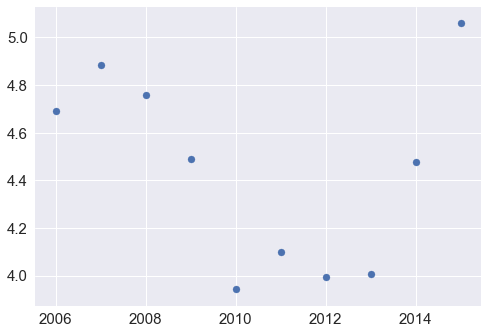

In [97]:
plt.scatter(np.arange(2006, 2016, 1), constant_lasso)

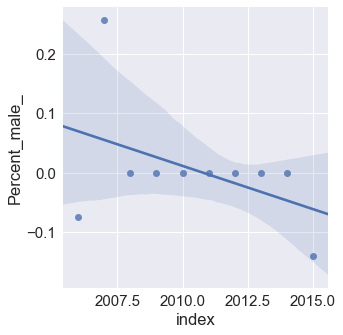

In [98]:
sns.lmplot(x = 'index', y = 'Percent_male_', data= coefficients_lasso.reset_index(), fit_reg = True)

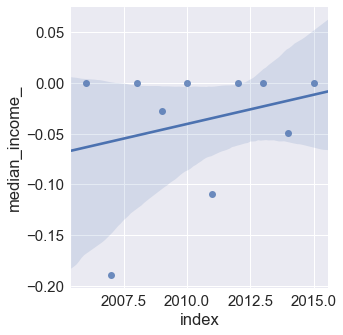

In [99]:
sns.lmplot(x = 'index', y = "median_income_", data= coefficients_lasso.reset_index(), fit_reg = True)


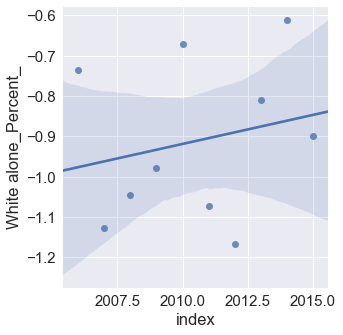

In [100]:
sns.lmplot(x = 'index', y = "White alone_Percent_", data= coefficients_lasso.reset_index(), fit_reg = True)


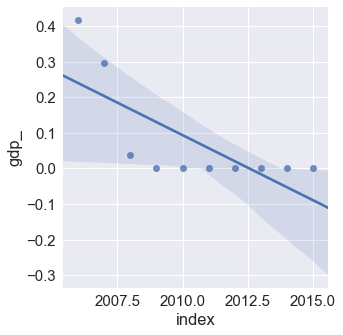

In [101]:
sns.lmplot(x = 'index', y = "gdp_", data= coefficients_lasso.reset_index(), fit_reg = True)

### Ridge Beta Visualization

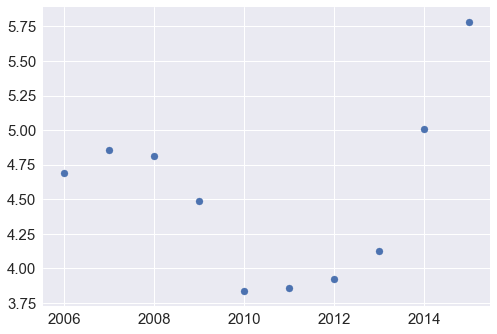

In [102]:
plt.scatter(np.arange(2006, 2016, 1), constant_ridge)

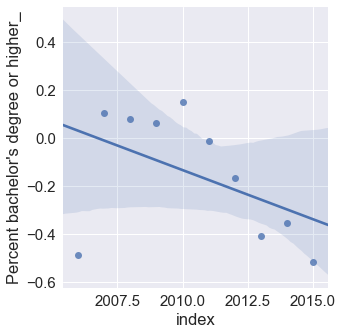

In [103]:
sns.lmplot(x = 'index', y = "Percent bachelor's degree or higher_", data= coefficients_ridge.reset_index(), fit_reg = True)

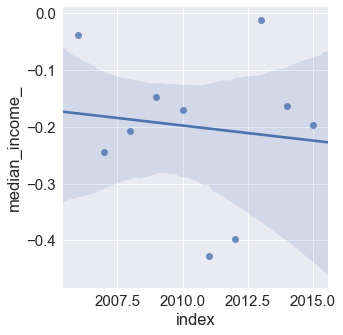

In [104]:
sns.lmplot(x = 'index', y = "median_income_", data= coefficients_ridge.reset_index(), fit_reg = True)

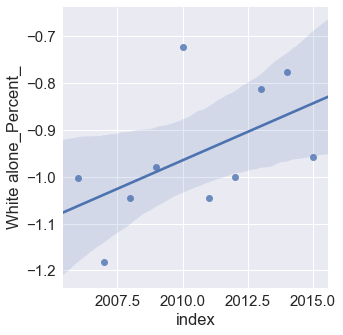

In [105]:
sns.lmplot(x = 'index', y = "White alone_Percent_", data= coefficients_ridge.reset_index(), fit_reg = True)

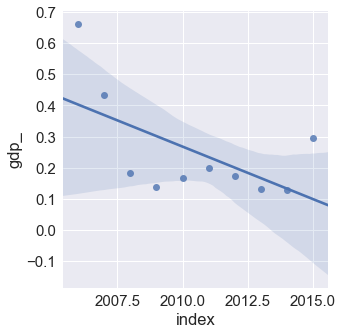

In [106]:
sns.lmplot(x = 'index', y = "gdp_", data= coefficients_ridge.reset_index(), fit_reg = True)

## Predicting 2016 Beta

In [107]:
# initialize dataframes to store projected betas for 2016 model
select_col = []
select_col_16 = []

model_lasso = pd.DataFrame()
model_ridge = pd.DataFrame()

# empty lists to fill 
predict_lasso = []
predict_ridge = []

# for every column
for col in columns:    
    if len(coefficients_lasso[col][coefficients_lasso[col].abs() > 0]) > 4:
    
        select_col.append(col)
        select_col_16.append(col + str(16))
        
        # fit a regression to the betas of each year
        regress_lasso = LinearRegression().fit(x.reshape(10, 1), coefficients_lasso[col])
        regress_ridge = LinearRegression().fit(x.reshape(10, 1), coefficients_ridge[col])
    
        # predict the beta of 2016
        predict_lasso.append(regress_lasso.predict(2016).tolist()[0])
        predict_ridge.append(regress_ridge.predict(2016).tolist()[0])

# add columns
model_lasso['columns'] = select_col
model_ridge['columns'] = select_col 

# model the constant
regress_lassoc = LinearRegression().fit(x.reshape(10,1), constant_lasso)
const_lasso = regress_lassoc.predict(2016)[0]
regress_ridgec = LinearRegression().fit(x.reshape(10,1), constant_ridge)
const_ridge = regress_ridgec.predict(2016)[0]

# add to df
model_lasso['coefficients'] = predict_lasso
model_ridge['coefficients'] = predict_ridge

In [108]:
model_lasso

,columns,coefficients
0,20_to_40_,-0.104122
1,Now married_,-0.181205
2,Divorced_,0.152026
3,Percent high school graduate or higher_,-0.071966
4,Percent bachelor's degree or higher_,-0.399958
5,poverty_,0.048383
6,median_income_,-0.005876
7,White alone_Percent_,-0.832224
8,Black or African American alone_Percent_,0.802572


In [109]:
model_ridge

,columns,coefficients
0,20_to_40_,-0.207377
1,Now married_,-0.293221
2,Divorced_,0.390282
3,Percent high school graduate or higher_,-0.365598
4,Percent bachelor's degree or higher_,-0.379171
5,poverty_,-0.139975
6,median_income_,-0.229550
7,White alone_Percent_,-0.819096
8,Black or African American alone_Percent_,0.862290


In [110]:
ones = np.ones((x_year[2016].shape[0],1))

# add constant to coefficient list
ylasso = model_lasso['coefficients'].values.tolist()
ylasso.insert(0, const_lasso)

# add constant to coefficient list
yridge = model_ridge['coefficients'].values.tolist()
yridge.insert(0, const_ridge)

# predict
lasso_hat = np.dot(np.hstack((ones, x_year[2016][select_col_16])), np.array([ylasso]).T) 
ridge_hat = np.dot(np.hstack((ones, x_year[2016][select_col_16])), np.array([yridge]).T)

# report
print('The R2 on the test set for using lasso to model the coefficients is', r2_score(y_year[2016] , lasso_hat.ravel()))
print('The R2 on the test set for using ridge to model the coefficients is', r2_score(y_year[2016] , ridge_hat.ravel()))


The R2 on the test set for using lasso to model the coefficients is 0.405715521583
The R2 on the test set for using ridge to model the coefficients is 0.444669689189


In [111]:
test_acc['Lasso (base + extra features)'] = r2_score(y_year[2016] , lasso_hat.ravel())
test_acc['Ridge (base + extra features)'] = r2_score(y_year[2016] , ridge_hat.ravel())

In [112]:
test_acc

,Lasso (Base),Ridge (Base),Lasso (base + extra features),Ridge (base + extra features)
0,0.058177,0.049318,0.405716,0.44467


## Average

In this method, we average over all years and take a subset of the averaged dataframe to train and test

In [113]:
colnames = dict_df_year[2006].columns.str.replace('06', '').tolist()

In [114]:
# msa df has all the msa names, good place to start search
msa_list = msa_df['msa_name'].values
df_avg = pd.DataFrame(columns = colnames)

In [115]:
# iterate over msas, look at trends in years for each feature
# average over these feature-trends
for i in range(len(msa_list)):
    new_row = []
    for j in range((dict_avg[2006].shape[1])):
        var_list = []
        for k in range(10):
            if dict_avg[2006 + k].loc[dict_avg[2006 + k]['msa_name'] == msa_list[i]].empty != True:
                var_list.append(dict_avg[2006 + k].loc[dict_avg[2006 + k]['msa_name'] == msa_list[i]].iloc[:, j].values[0])
            else:
                var_list.append(np.nan)
        var_list = np.array(var_list)
        if j == 20:
            avg = msa_list[i]
        elif j == 22:
            avg = unique_id.loc[unique_id['msa_name'] == msa_list[i]]['ID'].values[0]
        else:
            if i == 3 and j == 0:
                print((var_list))
                print(dict_avg[2006 + k].loc[dict_avg[2006 + k]['msa_name'] == msa_list[i]])
            avg = np.mean(var_list[~np.isnan(var_list)])
        new_row.append(avg)
    df_avg.loc[i] =new_row

[ 0.47601507  0.48071169         nan  0.47601042  0.477668    0.47350217
  0.47447732  0.47534826  0.46781698  0.46696434]
   Percent_male_15  Percent_female_15  AGE - 80 to 84 years_15  \
2         0.466964           0.533036                      1.9   

   AGE - 85 years and over_15  Now married_15  Widowed_15  Divorced_15  \
2                         1.6            39.4         7.8         12.6   

   Separated_15  Never married_15  Percent high school graduate or higher_15  \
2           5.2              35.0                                       82.3   

      ...       Two or more races:_Percent_15    msa_name  Murder 2015     ID  \
2     ...                            0.017504  Albany, GA         12.0  10500   

   gdp_15  murder_rate  under_18_15  20_to_40_15  40_to_60_15  60_above_15  
2   29235     7.643458         28.5         24.4         26.3         20.9  

[1 rows x 29 columns]


In [116]:
df_avg = df_avg.dropna(axis = 0)

In [117]:
base_col = ['Percent_male_' , 'under_18_', '20_to_40_', '40_to_60_', '60_above_', 'median_income_']

# train/test split
np.random.seed(9001)
msk = np.random.randn(df_avg.shape[0]) < 0.7
df_train = df_avg[msk]
df_test = df_avg[~msk]

# specific training/testing columns
x_train = df_train[base_col]
x_test = df_test[base_col]
y_train = df_train['murder_rate']
y_test = df_test['murder_rate']

# standardizing
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [118]:
lassoavg = LassoCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Lasso = %s'%(lassoavg.score(x_test, y_test)))
ridgeavg = RidgeCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Ridge = %s'%(ridgeavg.score(x_test, y_test)))

Test R^2 with Lasso = 0.152184287169
Test R^2 with Ridge = 0.155698225619


In [119]:
test_acc['Lasso (Base Average)'] = lassoavg.score(x_test, y_test)
test_acc['Ridge (Base Average)'] = ridgeavg.score(x_test, y_test)

(0, 20)

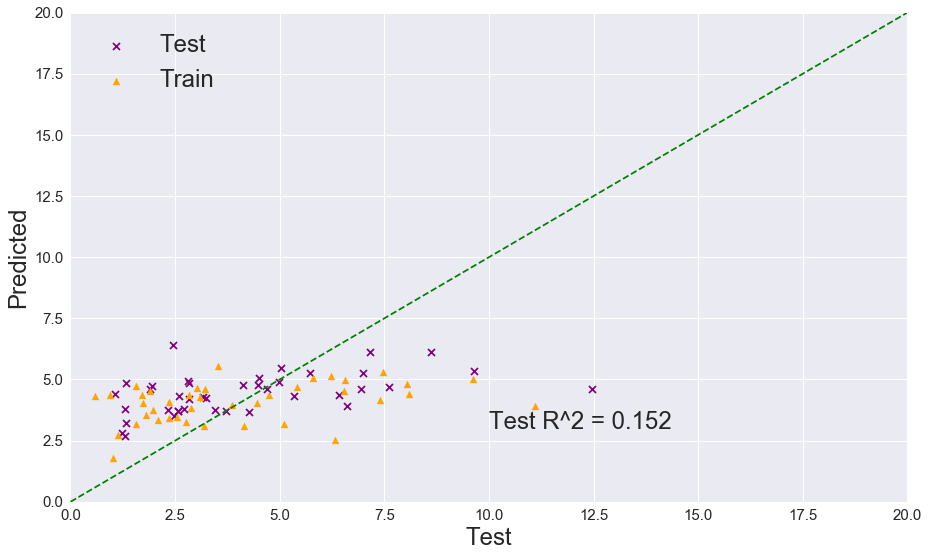

In [120]:
plt.figure(figsize=(15,9))
ypred = lassoavg.predict(x_test)[0:40]
plt.scatter(y_test[0:40], ypred, c='purple', marker = 'x', label = 'Test')
plt.scatter(y_train[0:40], lassoavg.predict(x_train)[0:40], c = 'orange', marker = '^', label = 'Train')

xvar = np.linspace(0,120,100)
plt.text(10,3,'Test R^2 = ' + str(round(lassoavg.score(x_test,y_test),3)),fontsize=24)
yvar = xvar
plt.plot(xvar,yvar,'--',c='g')
plt.xlabel('Test', fontsize = 24)
plt.ylabel('Predicted',fontsize = 24)
plt.legend(loc=2,prop={'size':24})


plt.ylim(0, 20)
plt.xlim(0, 20)

In [121]:
base_col = ['Percent_male_', 'Now married_', 'Widowed_', 'Divorced_','Separated_', 'Never married_','Percent high school graduate or higher_',"Percent bachelor's degree or higher_", 'poverty_', 'median_income_','White alone_Percent_', 'Black or African American alone_Percent_','American Indian and Alaska Native alone_Percent_','Asian alone_Percent_','Native Hawaiian and Other Pacific Islander alone_Percent_','Some other race alone_Percent_', 'Two or more races:_Percent_', 'under_18_', '20_to_40_','40_to_60_', '60_above_', 'gdp_']

In [122]:
# train/test split
np.random.seed(9001)
msk = np.random.randn(df_avg.shape[0]) < 0.7
df_train = df_avg[msk]
df_test = df_avg[~msk]

# specific training/testing columns
x_train = df_train[base_col]
x_test = df_test[base_col]
y_train = df_train['murder_rate']
y_test = df_test['murder_rate']

# standardizing
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

lassoavg = LassoCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Lasso = %s'%(lassoavg.score(x_test, y_test)))
ridgeavg = RidgeCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Ridge = %s'%(ridgeavg.score(x_test, y_test)))
rfavg = RandomForestRegressor().fit(x_train, y_train)
print('Test R^2 with RF = %s'%(rfavg.score(x_test, y_test)))

Test R^2 with Lasso = 0.604330356174
Test R^2 with Ridge = 0.639956016422
Test R^2 with RF = 0.595157101937


Feature ranking:
1. feature 11 (0.388603)
2. feature 10 (0.162002)
3. feature 4 (0.089568)
4. feature 16 (0.032254)
5. feature 0 (0.031671)
6. feature 3 (0.027373)
7. feature 1 (0.026191)
8. feature 18 (0.025638)
9. feature 15 (0.020576)
10. feature 12 (0.020480)
11. feature 5 (0.019303)
12. feature 6 (0.019169)
13. feature 14 (0.018102)
14. feature 17 (0.017262)
15. feature 7 (0.017215)
16. feature 21 (0.014445)
17. feature 20 (0.013815)
18. feature 19 (0.013814)
19. feature 9 (0.013720)
20. feature 2 (0.011951)
21. feature 13 (0.011079)
22. feature 8 (0.005770)


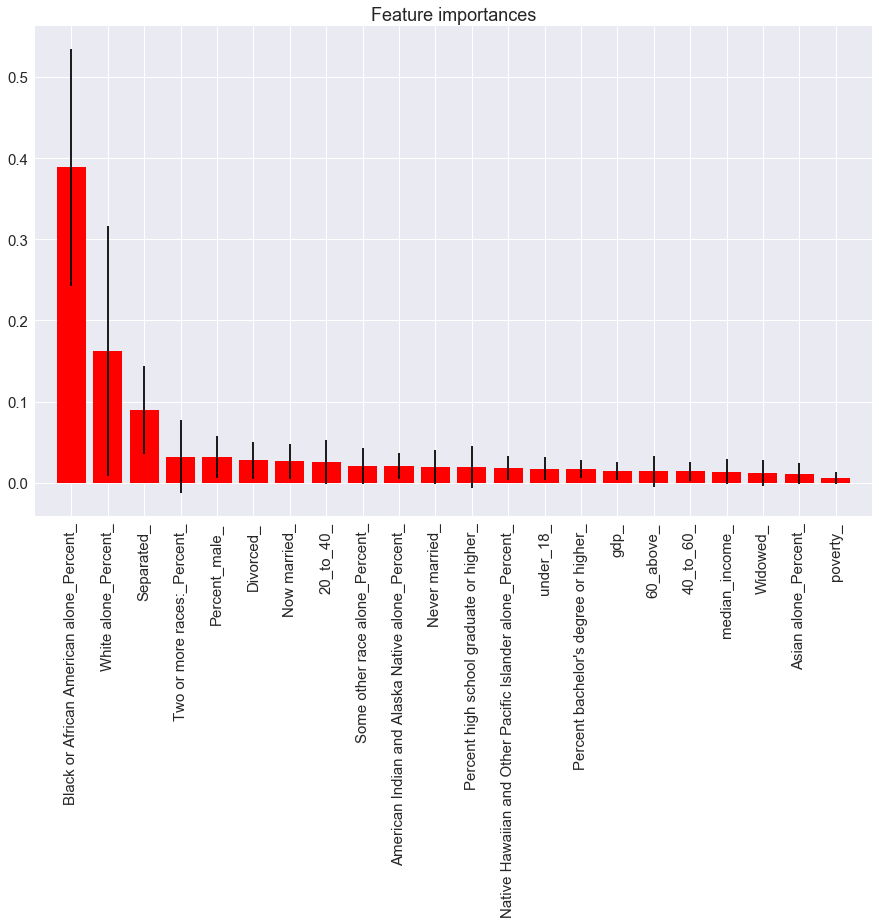

In [123]:
importances = rfavg.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfavg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

newlab = [base_col[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,9))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), newlab,rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [124]:
test_acc['Lasso (base+add features average)'] = lassoavg.score(x_test, y_test)
test_acc['Ridge (base+add features average)'] = ridgeavg.score(x_test, y_test)
test_acc['RF (base+add features average)'] = rfavg.score(x_test, y_test)


(0, 20)

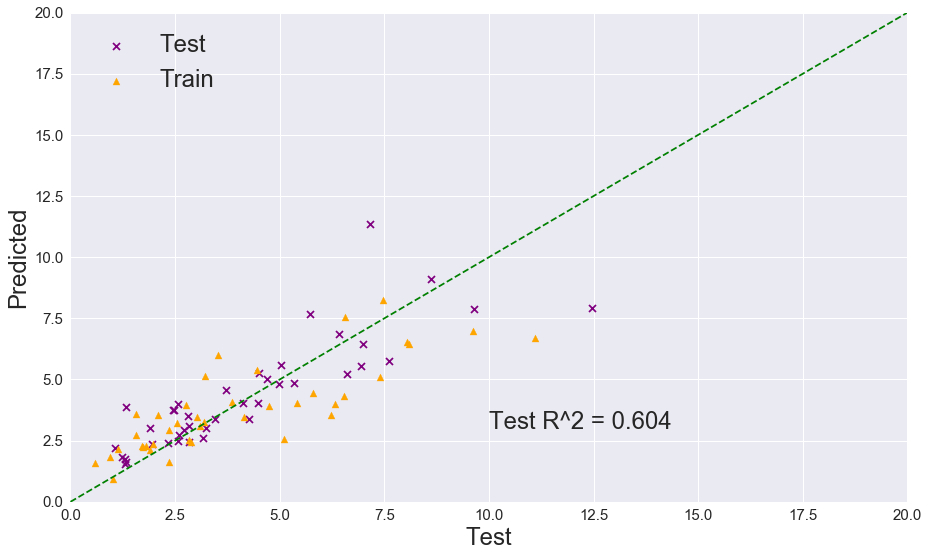

In [125]:
plt.figure(figsize=(15, 9))
ypred = lassoavg.predict(x_test)[0:40]
plt.scatter(y_test[0:40],ypred,c='purple',marker = 'x',label = 'Test')
plt.scatter(y_train[0:40],lassoavg.predict(x_train)[0:40],c='orange',marker = '^',label = 'Train')

xvar = np.linspace(0,20 ,10)
plt.text(10, 3, 'Test R^2 = ' + str(round(lassoavg.score(x_test, y_test), 3)),fontsize = 24)
yvar = xvar
plt.plot(xvar,yvar,'--',c='g')
plt.xlabel('Test',fontsize=24)
plt.ylabel('Predicted',fontsize=24)
plt.legend(loc = 2,prop = {'size':24})

plt.ylim(0, 20)
plt.xlim(0, 20)



In [126]:
# train/test split
np.random.seed(9001)
msk = np.random.randn(df_avg.shape[0]) < 0.7
df_train = df_avg[msk]
df_test = df_avg[~msk]

# specific training/testing columns
x_train = df_train[base_col]
x_test = df_test[base_col]
y_train = df_train['murder_rate']
y_test = df_test['murder_rate']

# standardizing
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

from sklearn.preprocessing import PolynomialFeatures

x_train, x_test = more_terms(x_train, x_test, 3)

lassoavg = LassoCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Lasso = %s'%(lassoavg.score(x_test, y_test)))
ridgeavg = RidgeCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Ridge = %s'%(ridgeavg.score(x_test, y_test)))
rfavg = RandomForestRegressor().fit(x_train, y_train)
print('Test R^2 with RF = %s'%(rfavg.score(x_test, y_test)))

Test R^2 with Lasso = 0.456706649263
Test R^2 with Ridge = -22.021980383
Test R^2 with RF = 0.565370070829


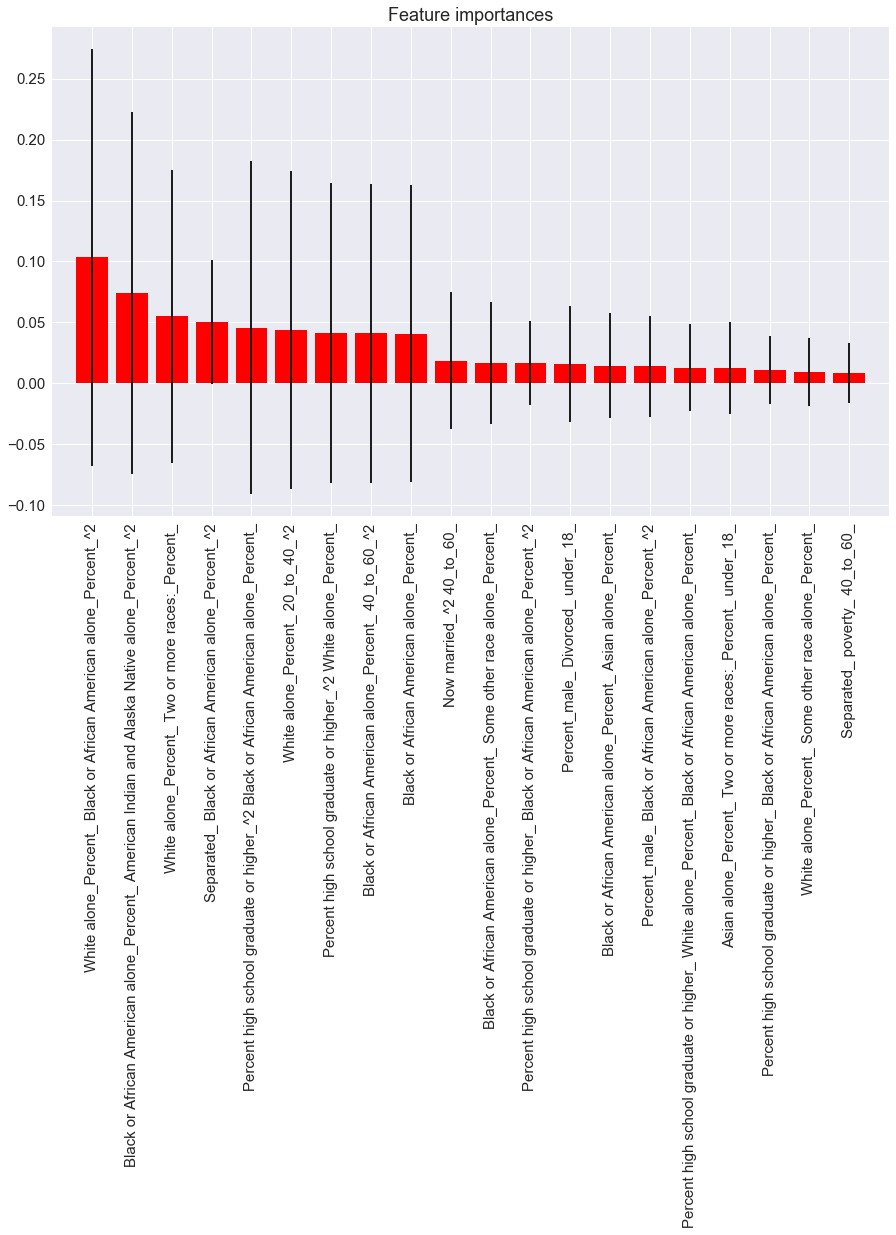

In [127]:
importances = rfavg.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfavg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

newlab = [x_train.columns[i] for i in indices]

# Plot the feature importances of the forest
plt.figure(figsize=(15,9))
plt.title("Feature importances")
plt.bar(range(20), importances[indices][0:20],
       color="r", yerr=std[indices][0:20], align="center")
plt.xticks(range(20), newlab[0:20],rotation=90)
plt.xlim([-1, 20])
plt.show()

In [128]:
test_acc['Lasso (complex features average)'] = lassoavg.score(x_test, y_test)
test_acc['Ridge (complex features average)'] = ridgeavg.score(x_test, y_test)
test_acc['RF (complex features average)'] = rfavg.score(x_test, y_test)


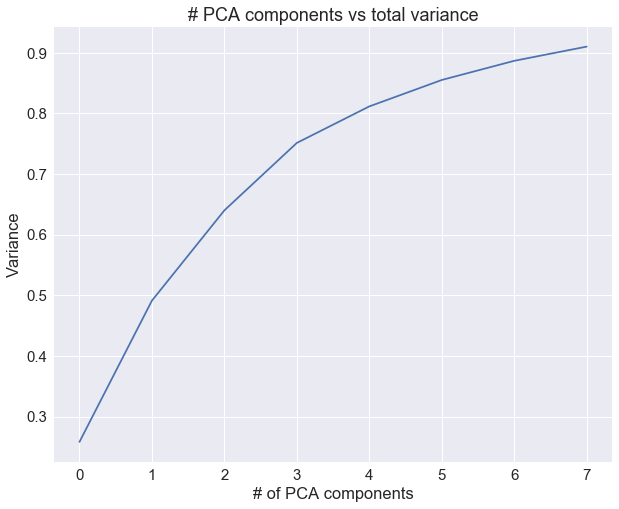

In [129]:
# train/test split
np.random.seed(9001)
msk = np.random.randn(df_avg.shape[0]) < 0.7
df_train = df_avg[msk]
df_test = df_avg[~msk]

# specific training/testing columns
x_train = df_train[base_col]
x_test = df_test[base_col]
y_train = df_train['murder_rate']
y_test = df_test['murder_rate']

# standardizing
scaler = MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

pcavar = []
i = 1
while True:
    pca = PCA(n_components = i)
    pca.fit(x_train)
    pcavar.append(pca.explained_variance_ratio_.sum())
    if (pca.explained_variance_ratio_.sum()) >= 0.9:
        break
    i += 1
    
plt.figure(figsize = (10,8))
plt.plot(pcavar)
plt.title('# PCA components vs total variance')
plt.ylabel('Variance')
plt.xlabel('# of PCA components')


In [130]:
pca = PCA(n_components = 7)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

lassoavg = LassoCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Lasso = %s'%(lassoavg.score(x_test, y_test)))
ridgeavg = RidgeCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Ridge = %s'%(ridgeavg.score(x_test, y_test)))
rfavg = RandomForestRegressor().fit(x_train, y_train)
print('Test R^2 with RF = %s'%(rfavg.score(x_test, y_test)))

Test R^2 with Lasso = 0.57626498613
Test R^2 with Ridge = 0.577600708353
Test R^2 with RF = 0.529015422912


In [131]:
test_acc['Lasso (PCA)'] = lassoavg.score(x_test, y_test)
test_acc['Ridge (PCA)'] = ridgeavg.score(x_test, y_test)
test_acc['RF (PCA)'] = rfavg.score(x_test, y_test)


# 2015 model

In this approach, we only use the 2015 dataset as train and the 2016 as test.

In [132]:
base_col = ['Percent_male_' , 'under_18_', '20_to_40_', '40_to_60_', '60_above_', 'median_income_']
dict15 = pd.DataFrame.copy(dict_df_year[2015])
colnames = dict15.columns.str.replace('15', '').tolist()
dict15.columns = colnames
dict15 = dict15.dropna(axis = 0)

dict16 = pd.DataFrame.copy(dict_df_year[2016])
colnames = dict16.columns.str.replace('16', '').tolist()
dict16.columns = colnames
dict16 = dict16.dropna(axis = 0)


In [133]:
x_train = dict15[base_col]
y_train = dict15['murder_rate']
x_test = dict16[base_col]
y_test = dict16['murder_rate'] 

scaler = StandardScaler().fit(x_train)
x_train =scaler.transform(x_train)
x_test = scaler.transform(x_test)

lassoavg = LassoCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Lasso = %s'%(lassoavg.score(x_test, y_test)))
ridgeavg = RidgeCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Ridge = %s'%(ridgeavg.score(x_test, y_test)))
rfavg = RandomForestRegressor().fit(x_train, y_train)
print('Test R^2 with RF = %s'%(rfavg.score(x_test, y_test)))

Test R^2 with Lasso = 0.184984007671
Test R^2 with Ridge = 0.185231612241
Test R^2 with RF = 0.382931023462


In [134]:
test_acc['Lasso (base 2015)'] = lassoavg.score(x_test, y_test)
test_acc['Ridge (base 2015)'] = ridgeavg.score(x_test, y_test)
test_acc['RF (base 2015)'] = rfavg.score(x_test, y_test)


In [135]:
base_col = ['Percent_male_', 'Now married_', 'Widowed_', 'Divorced_','Separated_', 'Never married_','Percent high school graduate or higher_',"Percent bachelor's degree or higher_", 'poverty_', 'median_income_','White alone_Percent_', 'Black or African American alone_Percent_','American Indian and Alaska Native alone_Percent_','Asian alone_Percent_','Native Hawaiian and Other Pacific Islander alone_Percent_','Some other race alone_Percent_', 'Two or more races:_Percent_','under_18_', '20_to_40_','40_to_60_', '60_above_', 'gdp_']

x_train = dict15[base_col]
y_train = dict15['murder_rate'] 
x_test = dict16[base_col]
y_test = dict16['murder_rate']

scaler = StandardScaler().fit(x_train)
x_train =scaler.transform(x_train)
x_test = scaler.transform(x_test)

lassoavg = LassoCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Lasso = %s'%(lassoavg.score(x_test, y_test)))
ridgeavg = RidgeCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Ridge = %s'%(ridgeavg.score(x_test, y_test)))
rfavg = RandomForestRegressor().fit(x_train, y_train)
print('Test R^2 with RF = %s'%(rfavg.score(x_test, y_test)))

Test R^2 with Lasso = 0.539690336936
Test R^2 with Ridge = 0.542384805987
Test R^2 with RF = 0.563916870639


In [136]:
test_acc['Lasso (base+add 2015)'] = lassoavg.score(x_test, y_test)
test_acc['Ridge (base+add 2015)'] = ridgeavg.score(x_test, y_test)
test_acc['RF (base+add 2015)'] = rfavg.score(x_test, y_test)


In [137]:
x_train = dict15[base_col]
y_train = dict15['murder_rate'] 
x_test = dict16[base_col]
y_test = dict16['murder_rate'] 

scaler = StandardScaler().fit(x_train)
x_train =scaler.transform(x_train)
x_test = scaler.transform(x_test)

x_train, x_test = more_terms(x_train, x_test, 3)

lassoavg = LassoCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Lasso = %s'%(lassoavg.score(x_test, y_test)))
ridgeavg = RidgeCV(fit_intercept = True).fit(x_train, y_train)
print('Test R^2 with Ridge = %s'%(ridgeavg.score(x_test, y_test)))
rfavg = RandomForestRegressor().fit(x_train, y_train)
print('Test R^2 with RF = %s'%(rfavg.score(x_test, y_test)))

Test R^2 with Lasso = 0.429372422981
Test R^2 with Ridge = -0.247138270863
Test R^2 with RF = 0.506115802568


In [138]:
test_acc['Lasso (complex 2015)'] = lassoavg.score(x_test, y_test)
test_acc['Ridge (complex 2015)'] = ridgeavg.score(x_test, y_test)
test_acc['RF (complex 2015)'] = rfavg.score(x_test, y_test)


In [139]:
test_acc.index = ['Test Accuracy']

In [140]:
# summary table
test_acc

,Lasso (Base),Ridge (Base),Lasso (base + extra features),Ridge (base + extra features),Lasso (Base Average),Ridge (Base Average),Lasso (base+add features average),Ridge (base+add features average),RF (base+add features average),Lasso (complex features average),...,RF (PCA),Lasso (base 2015),Ridge (base 2015),RF (base 2015),Lasso (base+add 2015),Ridge (base+add 2015),RF (base+add 2015),Lasso (complex 2015),Ridge (complex 2015),RF (complex 2015)
Test Accuracy,0.058177,0.049318,0.405716,0.44467,0.152184,0.155698,0.60433,0.639956,0.595157,0.456707,...,0.529015,0.184984,0.185232,0.382931,0.53969,0.542385,0.563917,0.429372,-0.247138,0.506116
